# TP2: Autoencoder - Learning to choose the best hyperparameters

An autoencoder (**AE**) is a special type of neural network that is trained to copy its input to its output. For example, given an image of a handwritten digit, an autoencoder first encodes the image into a lower dimensional latent representation, then decodes the latent representation back to an image. An autoencoder learns to compress the data while minimizing the reconstruction error. This is an example of unsupervised learning. Autoencoder can be used to learn representation (the by product of the encoder), and to detect anomalies.  

An autoencoder consists in two blocks: 
- the encoder projects the input in a latent space of "reduced" dimension (in comparison with the input). 
- the decoder maps some latent representation back in the input space. 

Basically, if you consider an input $\mathbf{x}$ : 
$$\mathbf{z} = encoder(\mathbf{x})$$
$$\mathbf{\tilde{x}} = decoder(\mathbf{z})$$

The goal is to train the AE, the goal is to minimize the reconstruction error. This error can be defined as the mean square error for instance : 
$\min||\mathbf{\tilde{x}}-\mathbf{x}||^2$


For this lab session, you can work with the MNIST dataset and we will train 3 different models:
- A linear Endoder/Decoder
- A non-linear Fully Connected Encoder/Decoder
- A Convolutional Encoder/Decoder

More details and constraints will be given through the practical session. 
Program:
1. Import Data and visualize the images 
2. Build a train/test wrapper
3. Train a linear model and understand how the latent dimension affects the reconstruction
4. Use the model to denoise
5. Use the model for anomaly detection
6. Train and use a Fully Connected model for denoising and anomaly detection
7. Train and use a Convolutional model for denoising and anomaly detection


First, we import the package required for the TP.

In [4]:
import numpy as np # Library for numerical calculations
import matplotlib.pyplot as plt # Library for plotting

import math # Library for mathematical functions

import torch # Library for tensor computations - for Deep Learning
import torch.nn as nn # Neural Network module
import torch.optim as optim # Optimization module
from torchvision import datasets, transforms # Computer Vision module

%matplotlib inline
%config InlineBackend.figure_formats=['retina']
%config InlineBackend.figure_format = 'retina'

Functions that will be useful to:
- Plot the reconstruction
- Plot the data in the latent space
- Print the number of parameters

In [5]:
def plot_result(model):
    """plot_result
    Plot the first 5 images of the test set and their reconstructions
    Input:
        - model: the trained model
    Output:
        - None
    """
    first_outputs = model(first_batch_images)
    plt.figure(figsize=(10, 4))
    for i in range(5):
        plt.subplot(2, 5, i + 1)
        plt.imshow(first_batch_images[i].cpu().numpy().reshape(28, 28), cmap="gray")
        plt.title("Input")
        plt.xticks([])
        plt.yticks([])
        plt.subplot(2, 5, i + 6)
        plt.imshow(first_outputs[i].cpu().detach().numpy().reshape(28, 28), cmap="gray")
        plt.title("Output")
        plt.xticks([])
        plt.yticks([])
    plt.show()


def plotLatentScatter(encoder, classes=None):
    """plotLatentScatter
    Plot the test dataset in the latent space of the encoder
    Input:
        - encoder: the encoder model
        - classes: the classes to plot
    Output:
        - None
    """
    latent_numpy = []
    labels_numpy = []
    for images, labels in test_loader:
        x = images
        latent_numpy.append(encoder(x).cpu().detach().numpy())
        labels_numpy.append(labels.numpy())
    if classes is None:
        classes = range(10)
    latent_numpy = np.concatenate(latent_numpy)
    labels_numpy = np.concatenate(labels_numpy)
    for c in classes:
        plt.scatter(
            latent_numpy[labels_numpy == c, 0],
            latent_numpy[labels_numpy == c, 1],
            marker="o",
            alpha=0.1,
            label=str(c),
        )
    plt.legend()
    plt.show()


def print_nparameters(model):
    """print_nparameters
    Print the number of parameters of the model
    Input:
        - model: the model
    Output:
        - None
    """
    nparameters = 0
    for parameter in model.parameters():
        nparameters += parameter.numel()
    print("Number of parameters:", nparameters)

# 1 Import Data and visualize the images 

In [6]:
train_dataset = datasets.MNIST(
    root="", train=True, transform=transforms.ToTensor(), download=True
)
test_dataset = datasets.MNIST(
    root="", train=False, transform=transforms.ToTensor(), download=True
)

print("Train dataset:", train_dataset, "\n")
print("Test dataset:", test_dataset)

Train dataset: Dataset MNIST
    Number of datapoints: 60000
    Root location: 
    Split: Train
    StandardTransform
Transform: ToTensor() 

Test dataset: Dataset MNIST
    Number of datapoints: 10000
    Root location: 
    Split: Test
    StandardTransform
Transform: ToTensor()


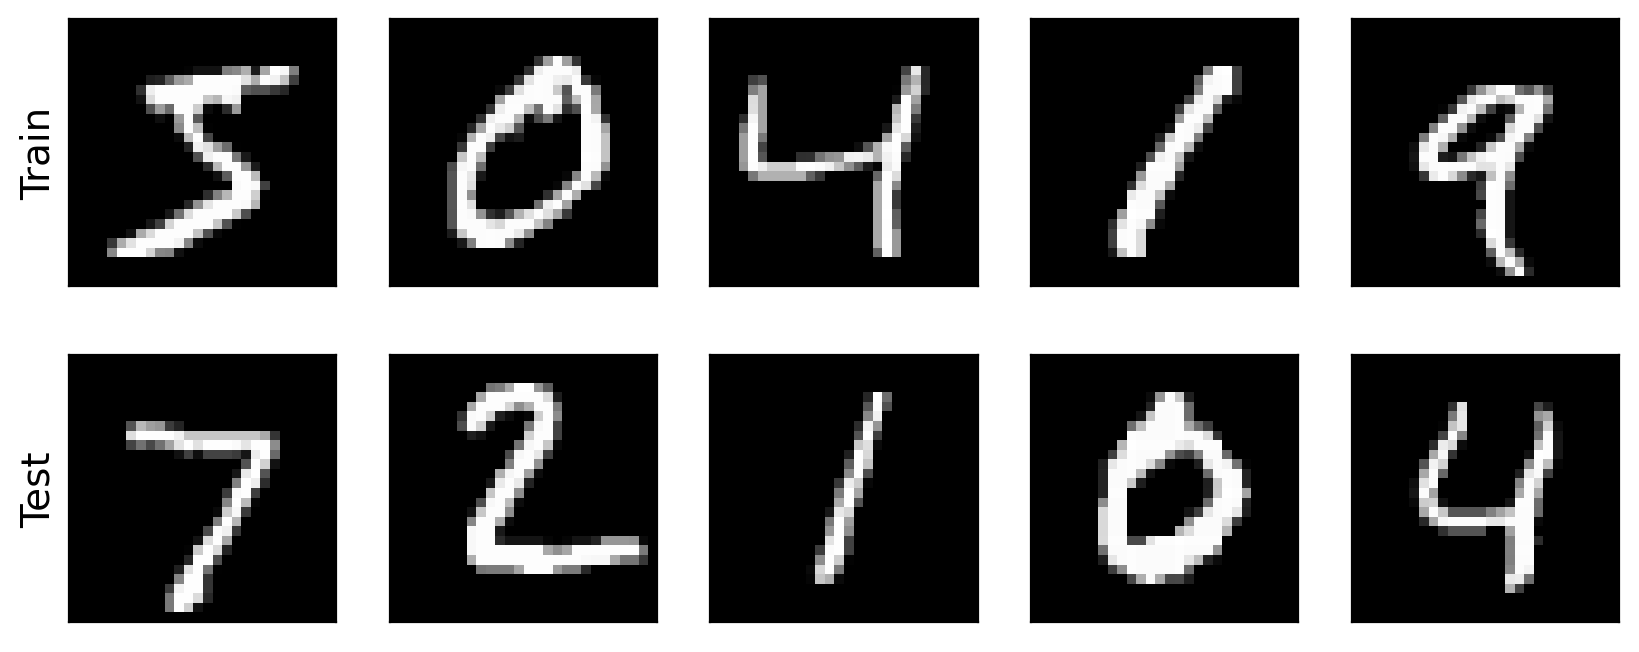

In [7]:
samples_train = train_dataset.data[:5]
samples_test = test_dataset.data[:5]
plt.figure(figsize=(10, 4))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    if i == 0:
        plt.ylabel("Train", fontsize=14)
    plt.imshow(samples_train[i], cmap="gray")
    plt.xticks([])
    plt.yticks([])
    plt.subplot(2, 5, i + 6)
    if i == 0:
        plt.ylabel("Test", fontsize=14)
    plt.imshow(samples_test[i], cmap="gray")
    plt.xticks([])
    plt.yticks([])

We need to build the dataloader: a function that cut the dataset in batches.

In [8]:
batch_size = 100
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False)

In [9]:
first_batch_images, first_batch_labels = next(iter(train_loader))
print("First batch:", first_batch_images.shape, first_batch_labels.shape)

First batch: torch.Size([100, 1, 28, 28]) torch.Size([100])


# 2 Wrapper for training and Evaluation 

The goal of this section is to automatize the process of training and testing the model. 

To do so, we will define a function that will take as input the model, the loss function, the optimizer, the number of epochs, and the train and test loaders. The function will return the loss of the model during the training and testing phases. 


<font color='blue'>TODO:</font> 
- Complete the AE_train function

In [10]:
def AE_eval(model, criterion):
    """AE_eval
    Evaluate the model on the test set
    Input:
        - model: the trained model
        - criterion: the loss function
    Output:
        - test_loss: the average loss on the test set
    """
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for images, _ in test_loader:
            images = images
            outputs = model(images)
            test_loss += criterion(outputs, images).item()
    return test_loss / len(test_loader)


def AE_train(model, criterion, optimizer, epochs=30, plot=True, verbose=False, freq=10):
    """AE_train
    Train the model
    Input:
        - model: the model to train
        - criterion: the loss function
        - optimizer: the optimization algorithm
        - epochs: the number of epochs
        - plot: if True, plot the train and test losses
        - verbose: if True, print the losses
        - freq: frequency of printing the losses
    Output:
        - train_losses: the train losses
        - test_losses: the test losses
    """
    if verbose:
        print("Start training...")
    train_losses = []
    test_losses = [AE_eval(model, criterion)]
    for e in range(epochs):
        for batch_idx, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            recons = model(images)
            loss = criterion(recons, images)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
            if verbose and batch_idx % freq == 0:
                print("Epoch %d, Batch %d, loss: %.4f" % (e, batch_idx, loss.item()))
        test_loss = AE_eval(model, criterion)
        test_losses.append(test_loss)
        if verbose:
            print("\t Epoch %d/%d, Test loss: %.4f" % (e + 1, epochs, test_loss))
    if plot:
        plt.plot(train_losses, label="Train loss")
        plt.plot(
            [e * batch_idx for e in range(e + 2)],
            test_losses,
            label="Test loss",
            marker="o",
            linewidth=0.0,
        )
        plt.legend()
        plt.xlabel("Batch")
        plt.ylabel("Loss")
        plt.show()
    return train_losses, test_losses

# 3 Linear Auto-encoder 

The basic idea is to have a linear transformation for both the encoder and decoder. 
For the output activation, we can use the sigmoid, since we know that the images are in greyscale, and the pixel values are between $0$ and $1$. 

The only hyperparameter we have is the dimension of the latent space: $h_{\mathrm{dim}} < 784$.

## 3.1 First model 


<font color='blue'>TODO:</font> 
- Write a class for the encoder
- Test it on some images as sanity-check using the *plot_result* function 



In [11]:
### Write the class
class AElin(nn.Module):
    """AElin
    Autoencoder with linear layers
    Parameters:
        - hdim: the dimension of the hidden layer
    """

    def __init__(self, hdim=2):
        super().__init__()
        # Use the function nn.Sequential to define the encoder and decoder
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, hdim),
            # nn.ReLU()
        )
        self.decoder = nn.Sequential(nn.Linear(hdim, 28 * 28), nn.Sigmoid())

    def encoder_function(self, x):
        x = x.view(x.size(0), -1)
        return self.encoder(x)

    def forward(self, x):
        x = x.reshape(x.size(0), -1)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        decoded = decoded.reshape(x.size(0), 1, 28, 28)
        return decoded

Number of parameters: 3922


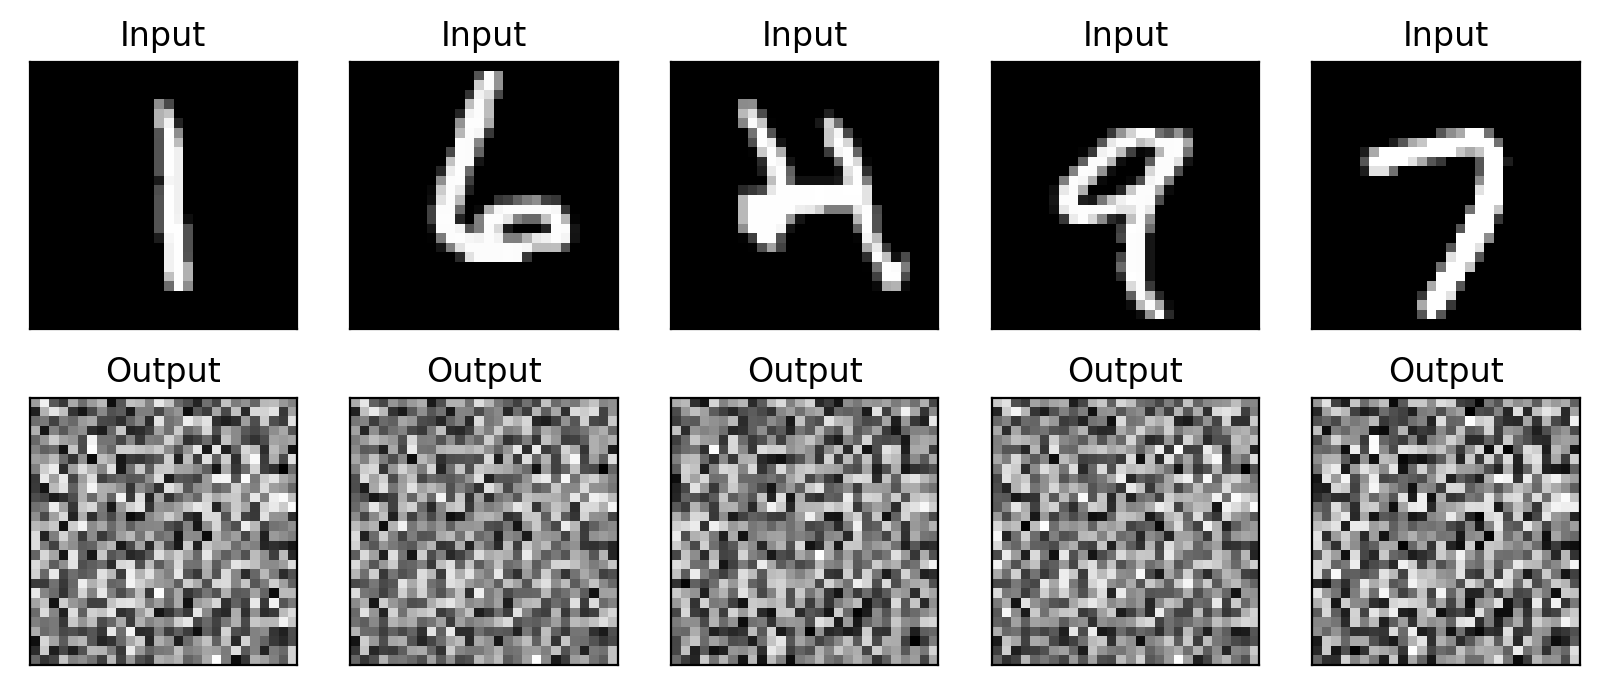

In [12]:
# Define the model and test it
model = AElin()
print_nparameters(model)
plot_result(model)

**TODO** 
- Train your model and plot the loss during training for 5 epochs.
- Observe the result



Number of parameters: 3922
Start training...
Epoch 0, Batch 0, loss: 0.2396
Epoch 0, Batch 100, loss: 0.2365
Epoch 0, Batch 200, loss: 0.2333


Epoch 0, Batch 300, loss: 0.2297
Epoch 0, Batch 400, loss: 0.2253
Epoch 0, Batch 500, loss: 0.2215
	 Epoch 1/3, Test loss: 0.2161
Epoch 1, Batch 0, loss: 0.2161
Epoch 1, Batch 100, loss: 0.2112
Epoch 1, Batch 200, loss: 0.2046
Epoch 1, Batch 300, loss: 0.2004
Epoch 1, Batch 400, loss: 0.1929
Epoch 1, Batch 500, loss: 0.1869
	 Epoch 2/3, Test loss: 0.1825
Epoch 2, Batch 0, loss: 0.1812
Epoch 2, Batch 100, loss: 0.1764
Epoch 2, Batch 200, loss: 0.1717
Epoch 2, Batch 300, loss: 0.1669
Epoch 2, Batch 400, loss: 0.1623
Epoch 2, Batch 500, loss: 0.1561
	 Epoch 3/3, Test loss: 0.1514


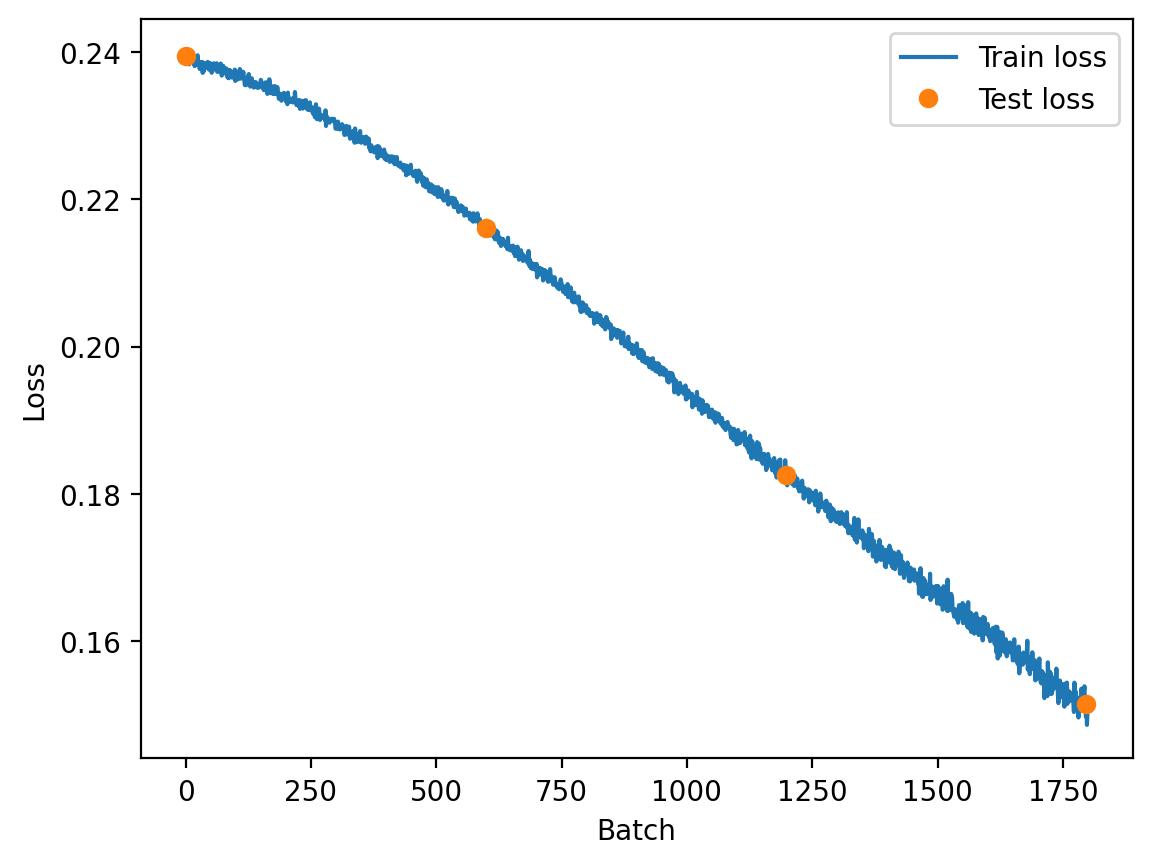

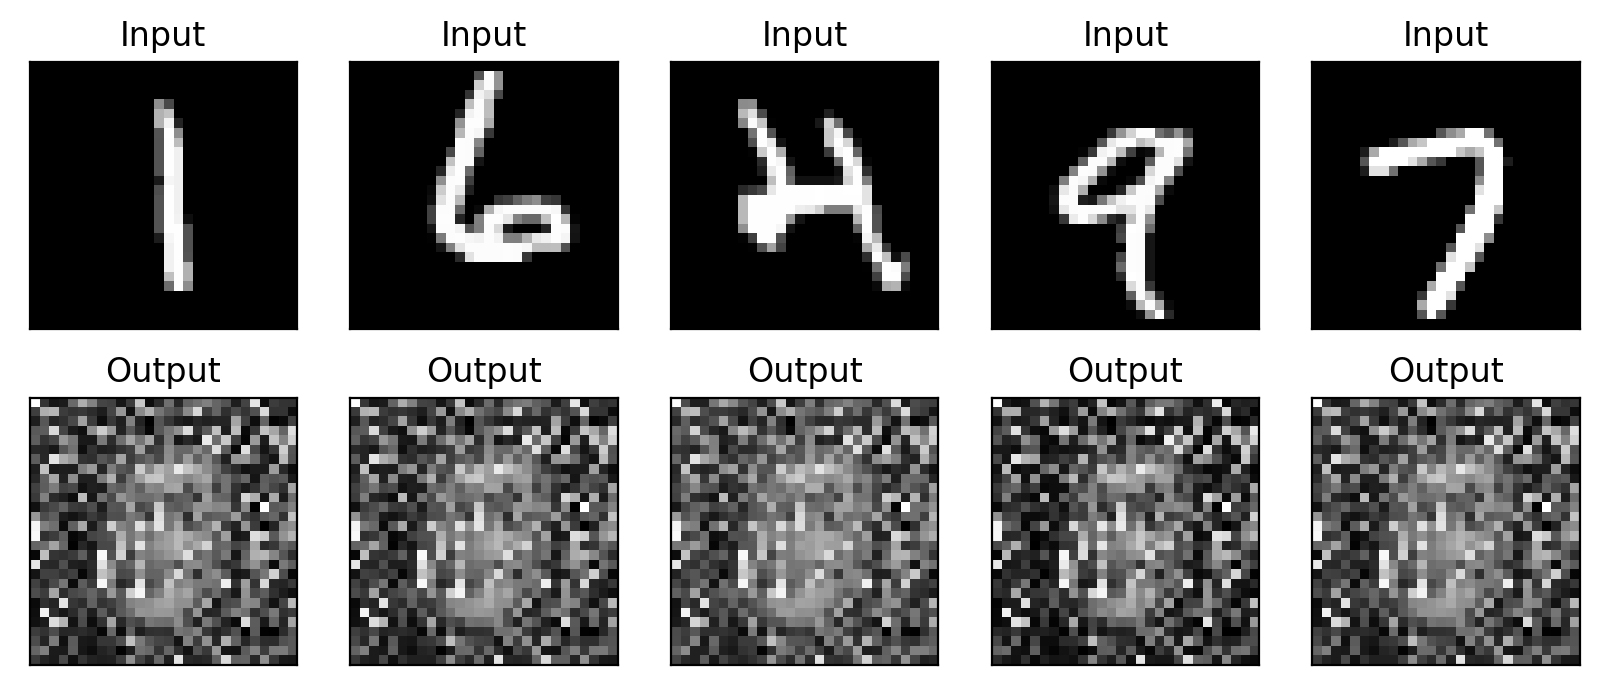

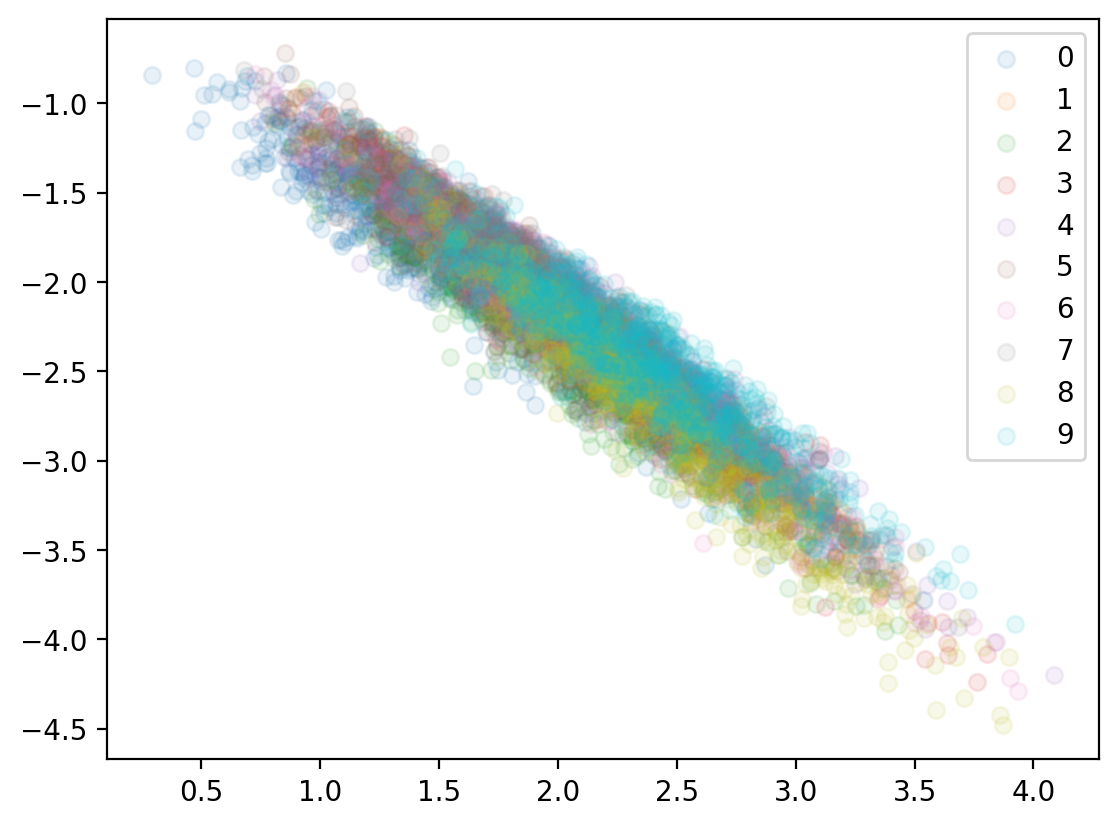

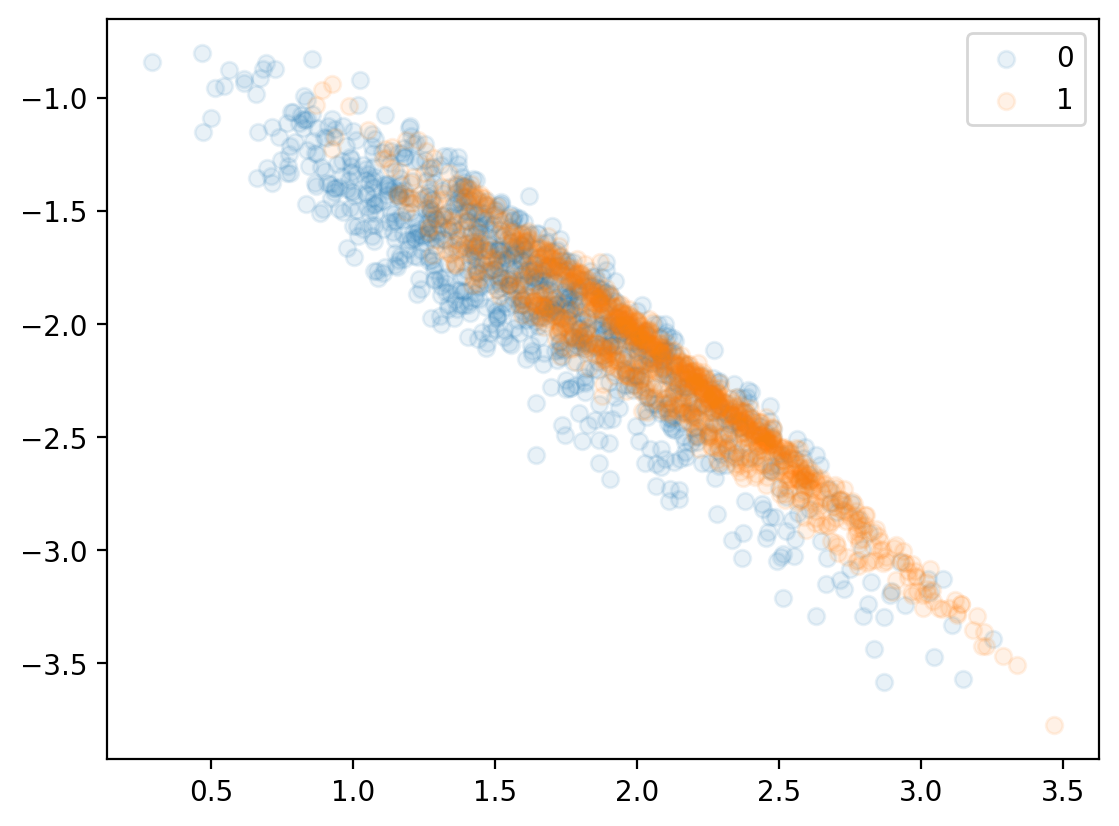

In [13]:
# Model Initialization
# model = AElin()
print_nparameters(model)

# Validation using MSE Loss function
lossAE = nn.MSELoss()

# Using an Adam Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

AE_train(model, lossAE, optimizer, epochs=3, plot=True, verbose=True, freq=100)
plot_result(model)
plotLatentScatter(model.encoder_function, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
plotLatentScatter(model.encoder_function, classes=[0, 1])

## 3.2 Try different hyperpameters

<font color='blue'>TODO:</font> 
- Try different latent dimension: 2, 10, 20 50, 100
- Try different learning rates: 1e-1, 1e-2, 1e-3, 1e-4, 1e-5

For each try, plot the reconstructions result and the losses.

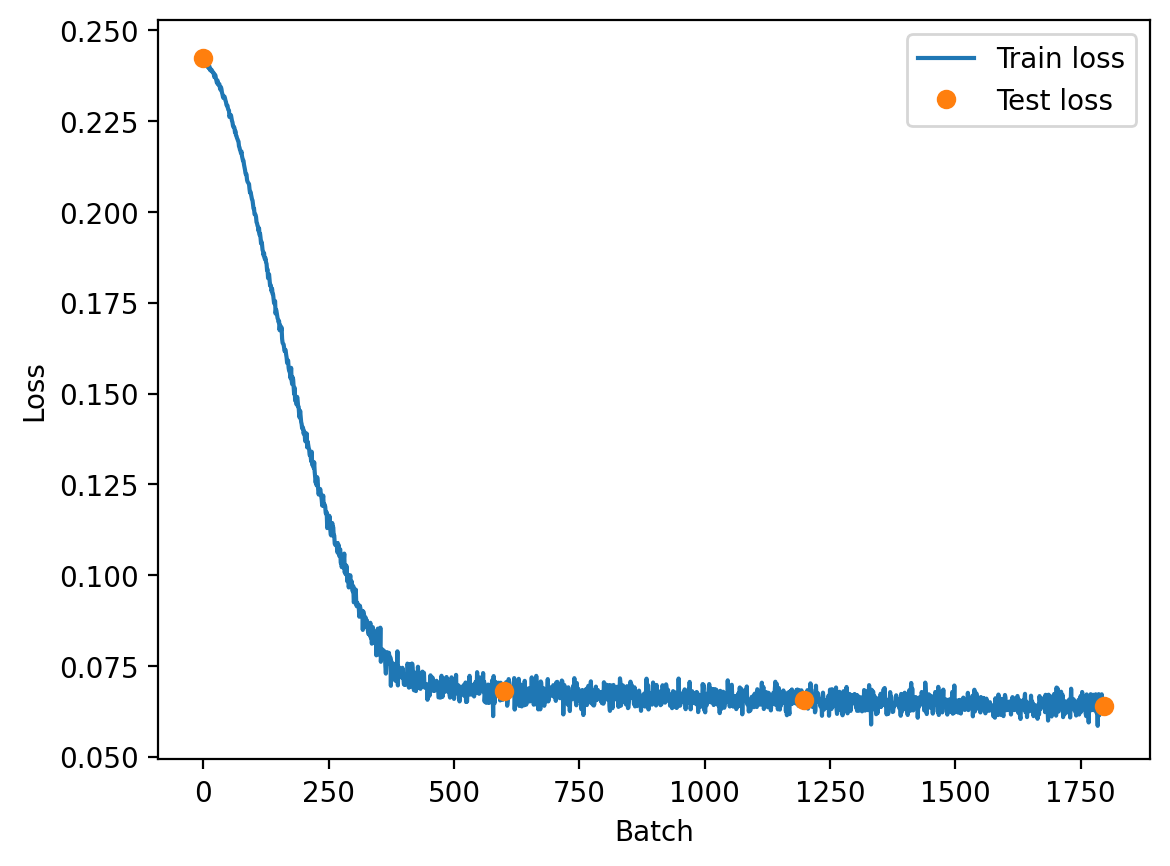

Hidden dimension: 2 Test loss: 0.0639419785514474


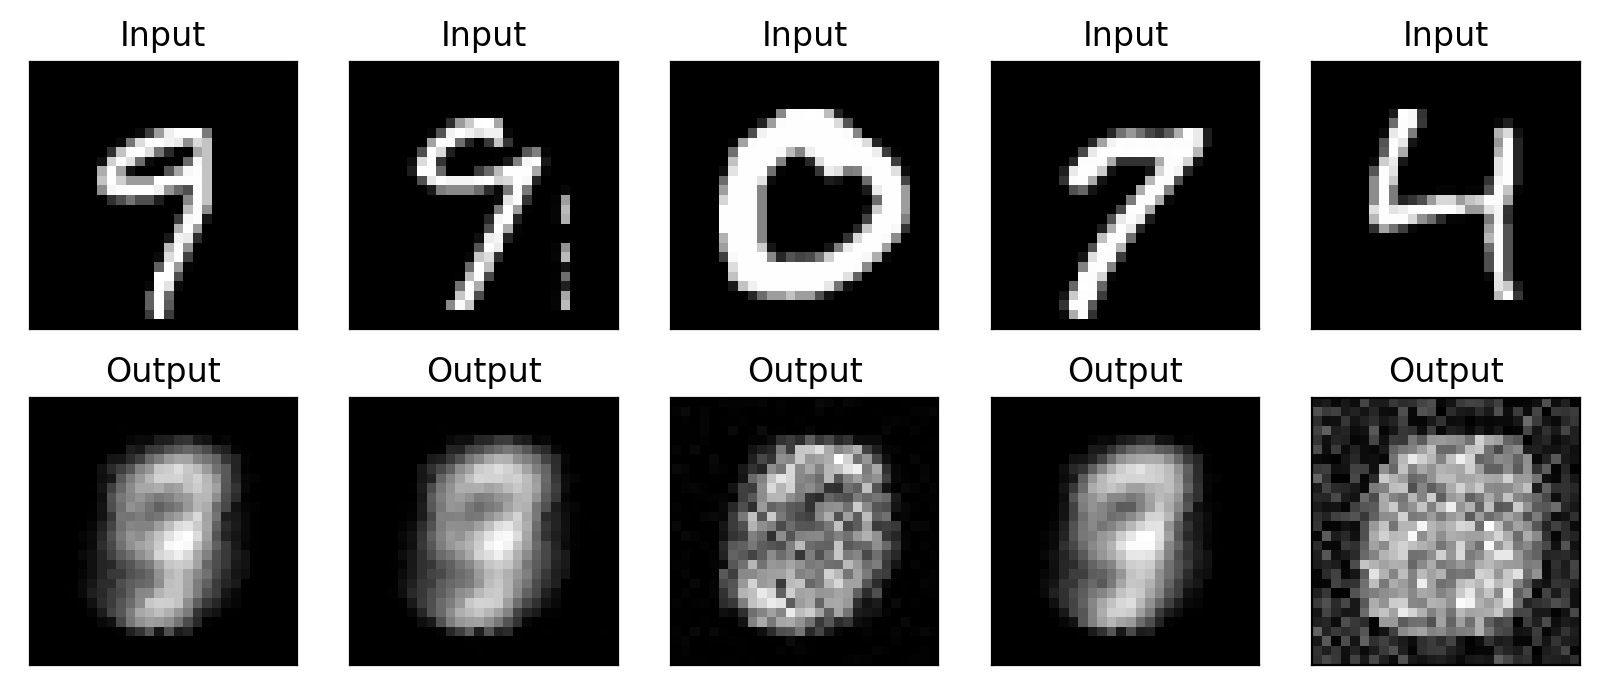

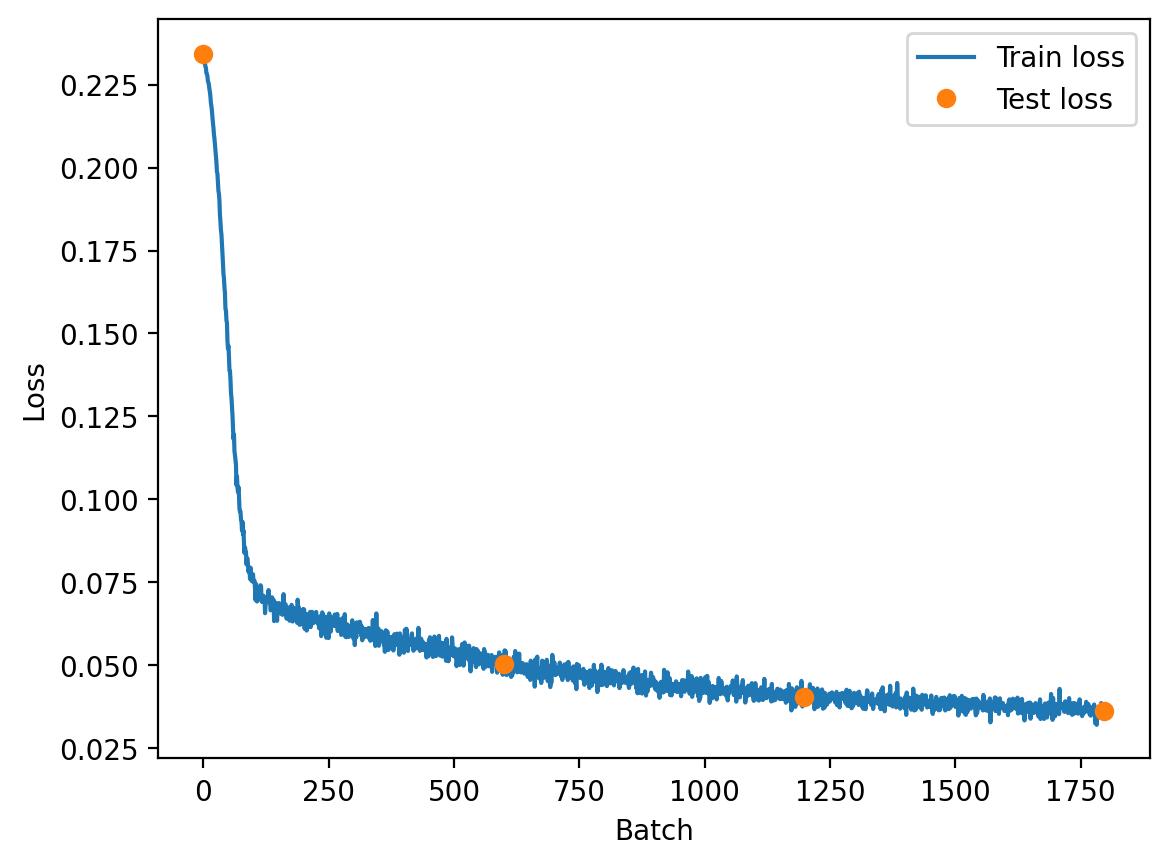

Hidden dimension: 10 Test loss: 0.036096497401595116


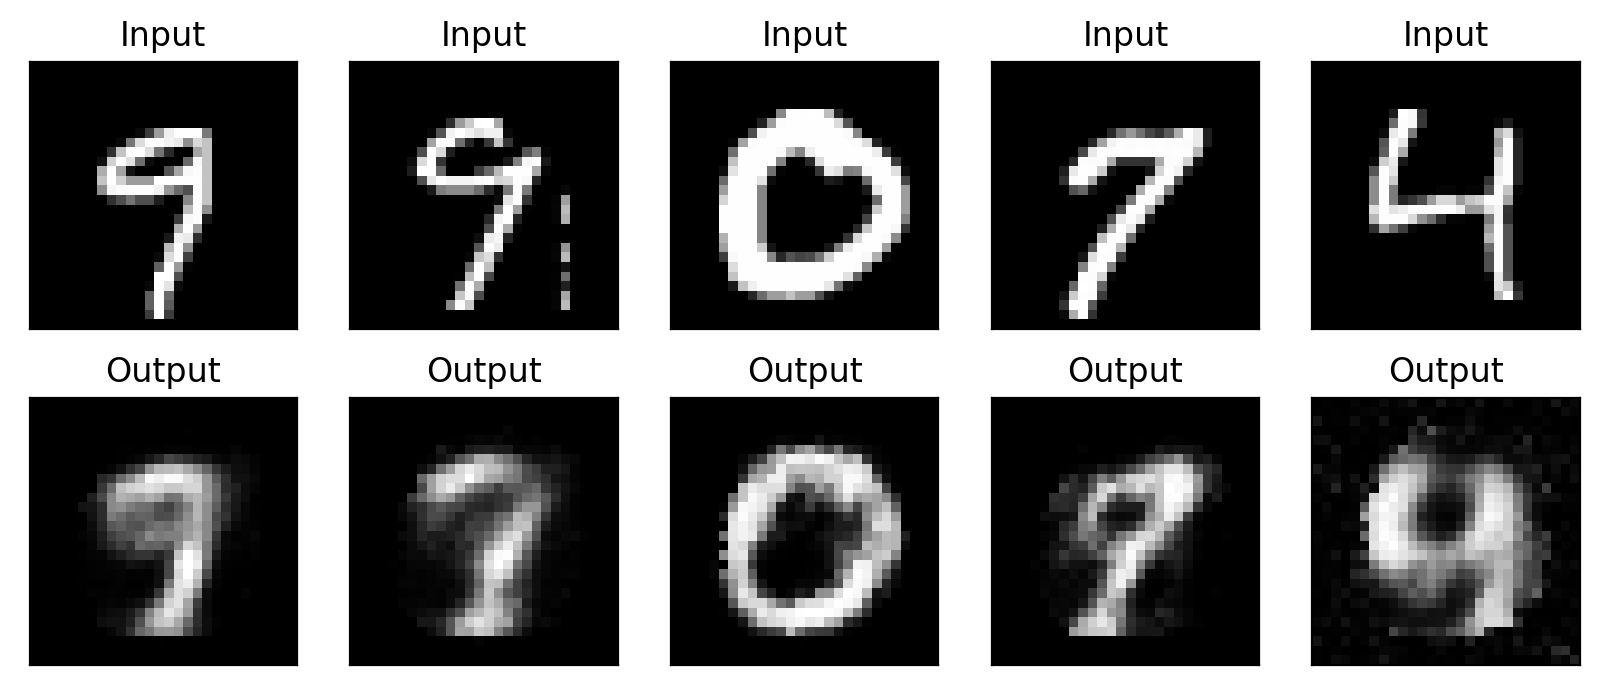

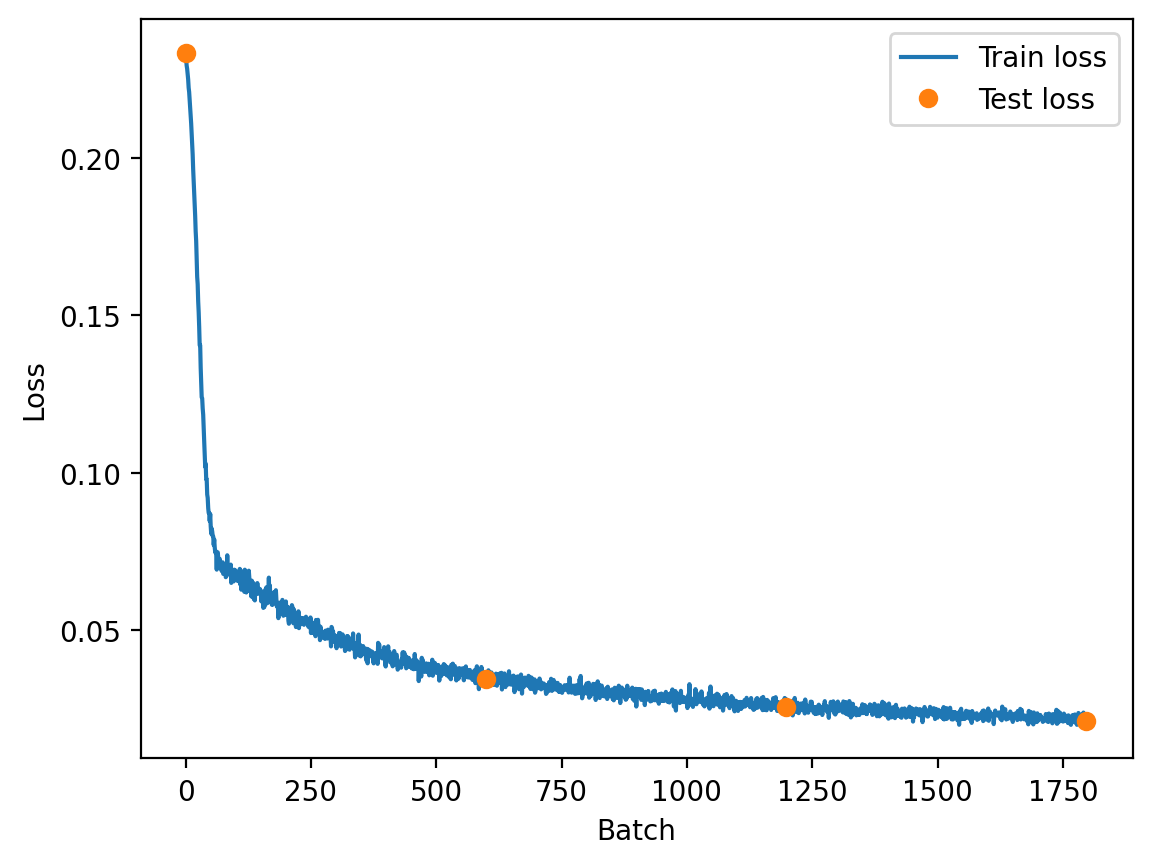

Hidden dimension: 20 Test loss: 0.021305526550859214


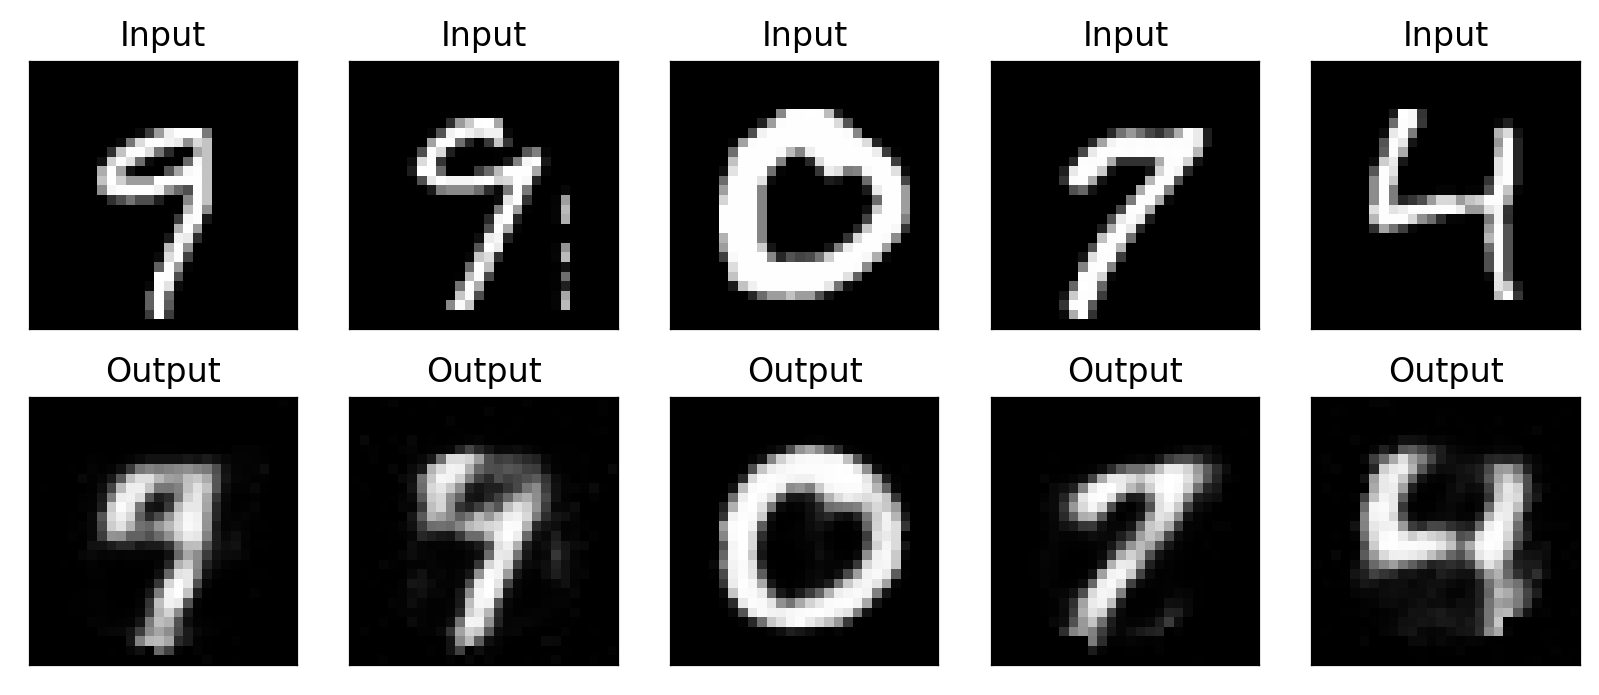

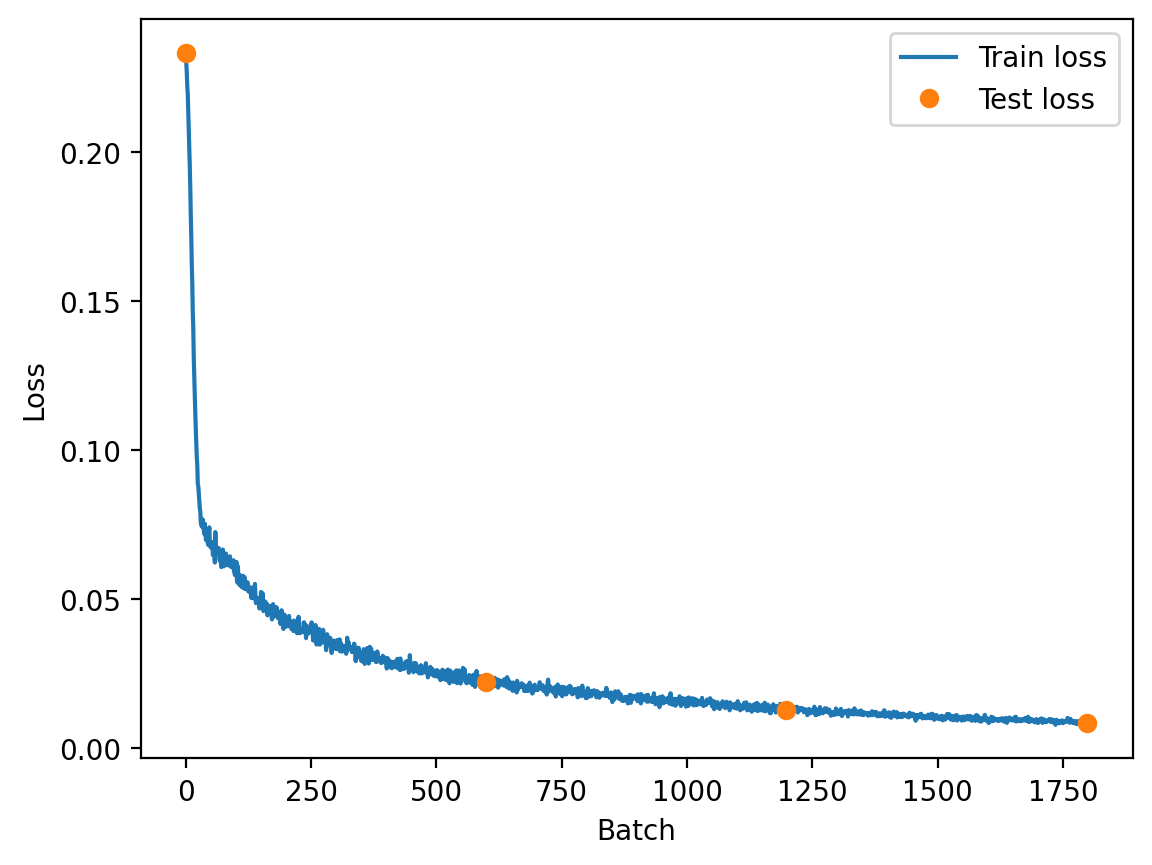

Hidden dimension: 50 Test loss: 0.008351349234580994


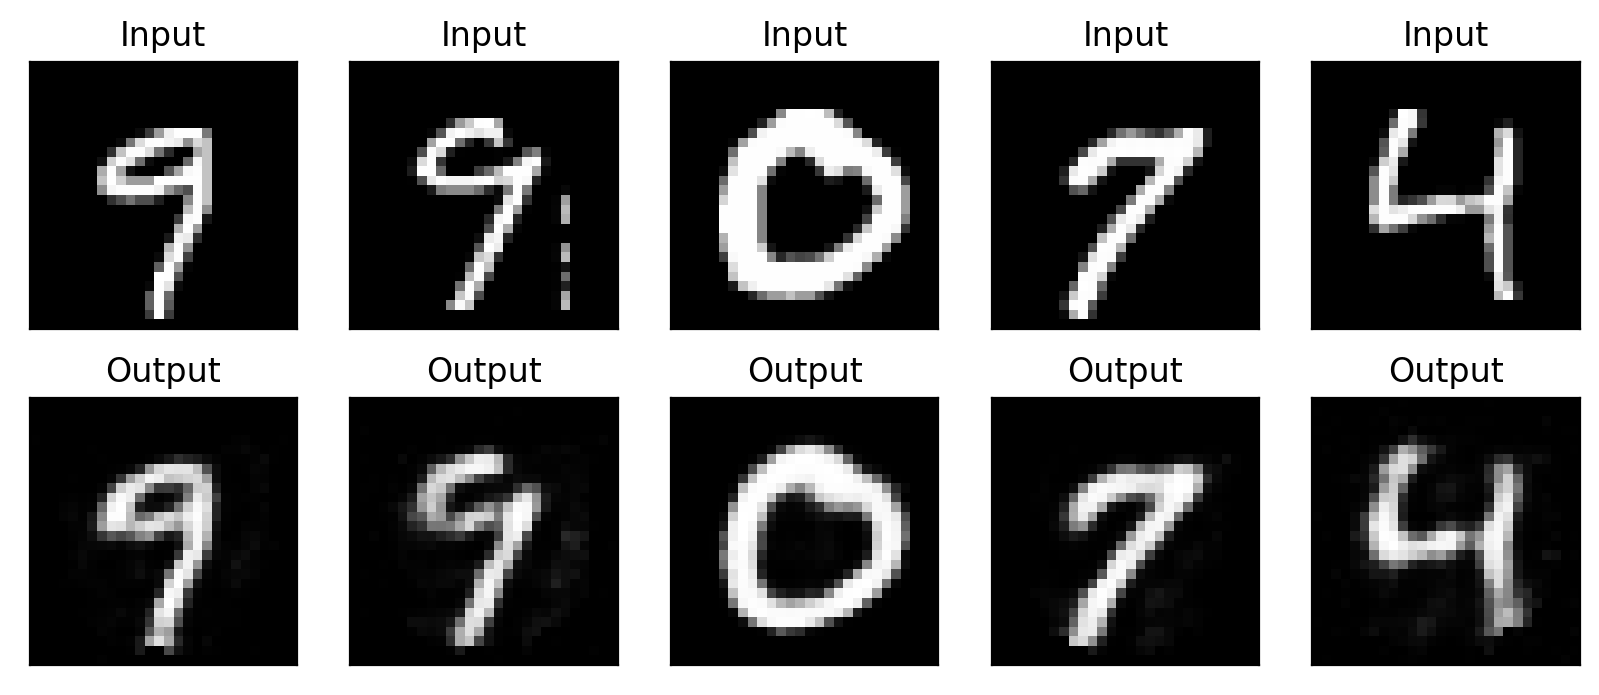

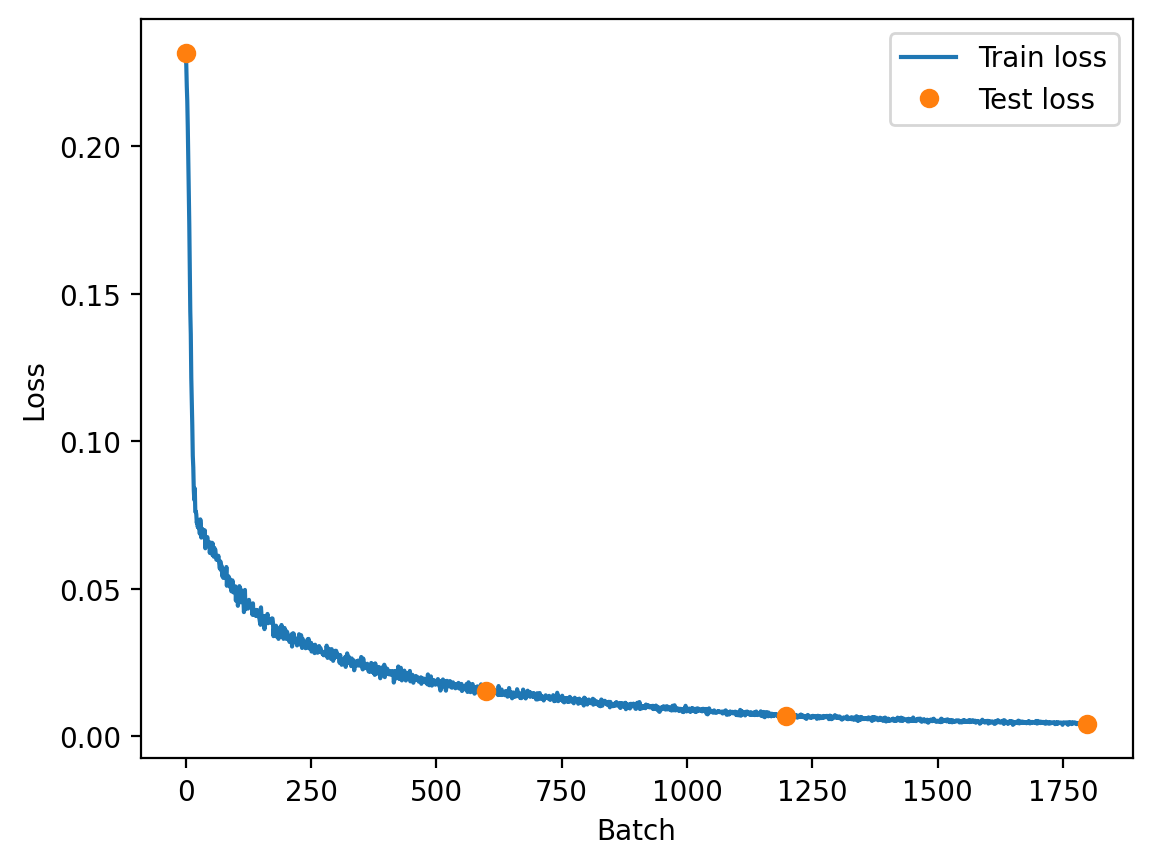

Hidden dimension: 100 Test loss: 0.0042265525693073866


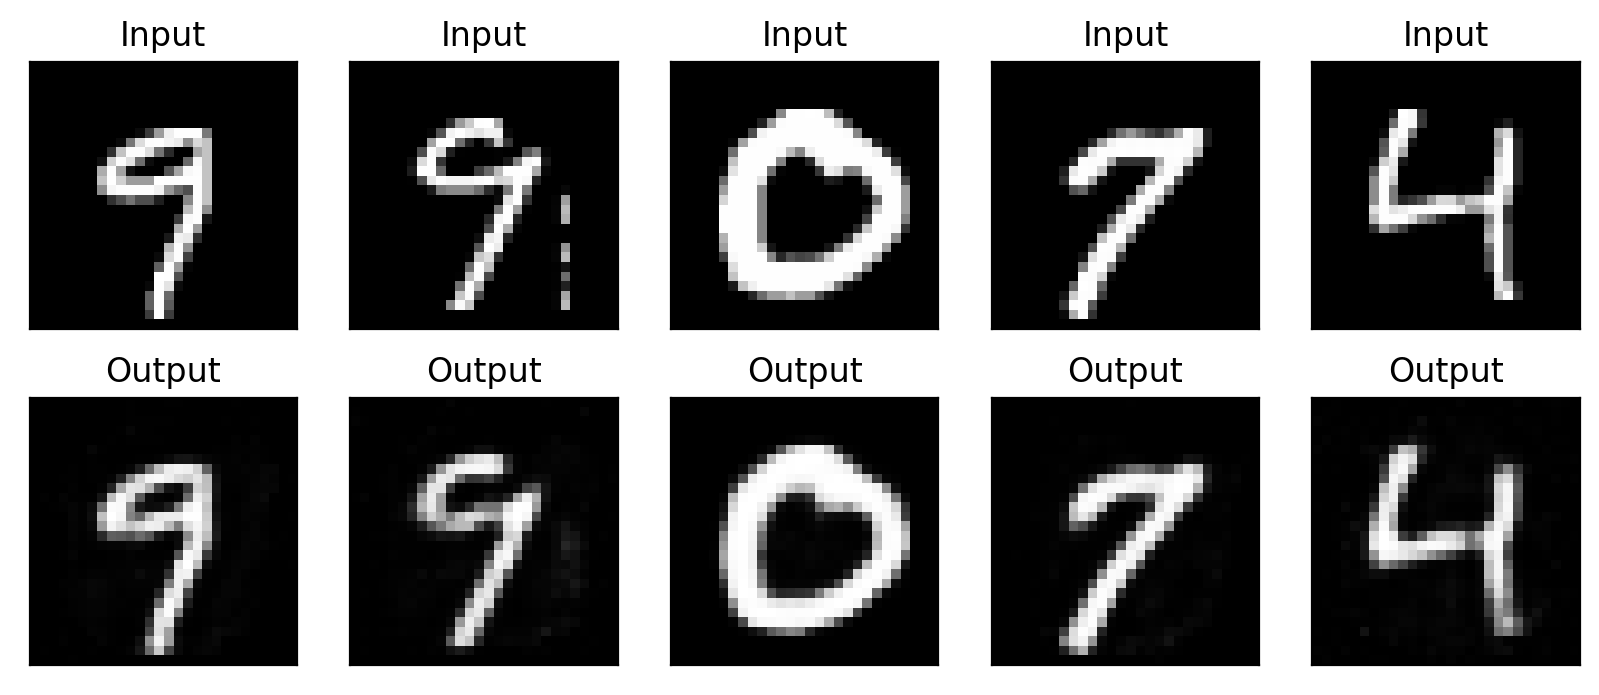

In [ ]:
# Hidden dimension
for h in [2, 10, 20, 50, 100]:
    AE = AElin(hdim=h)
    optimizer = optim.Adam(AE.parameters(), lr=1e-3)
    _, loss_eval = AE_train(
        AE, lossAE, optimizer, epochs=3, plot=True, verbose=False, freq=100
    )
    print("Hidden dimension:", h, "Test loss:", loss_eval[-1])
    plot_result(AE)

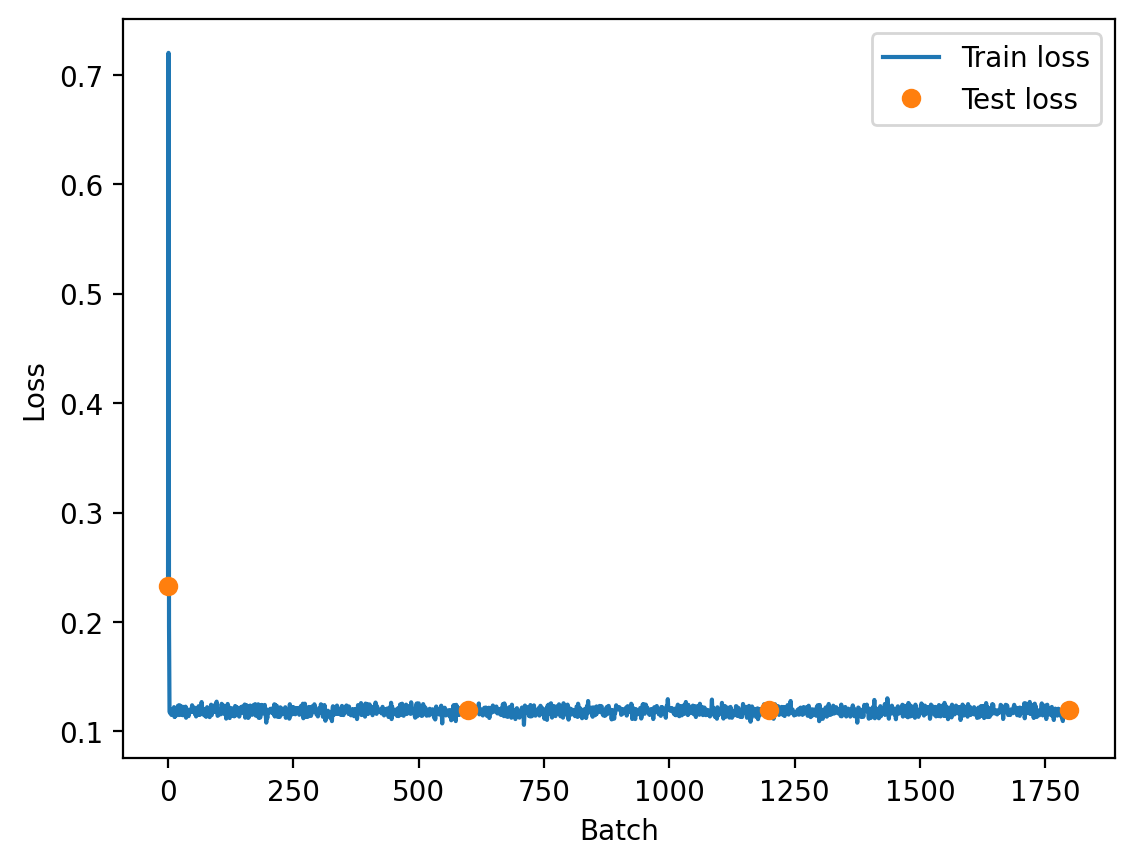

Learning rate: 0.1 Test loss: 0.11937380835413933


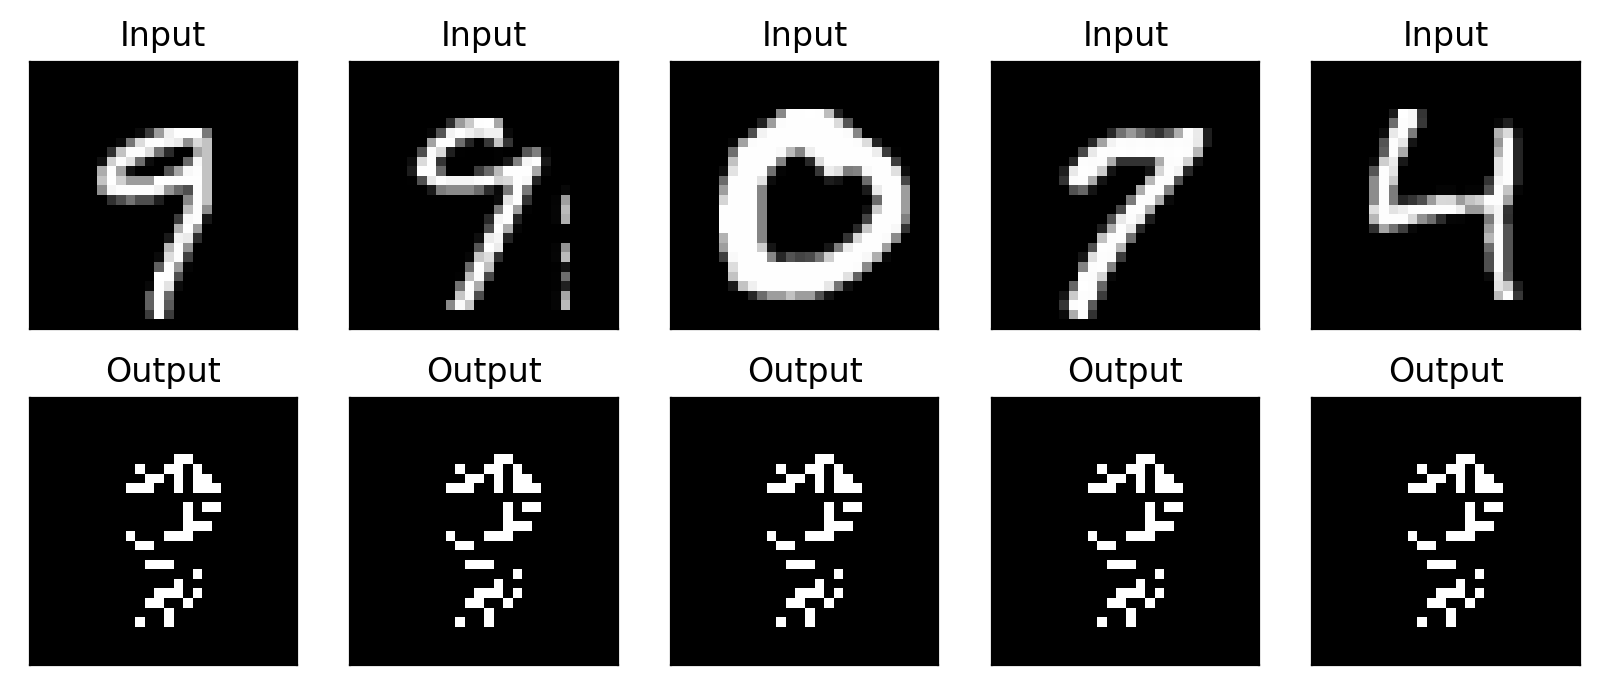

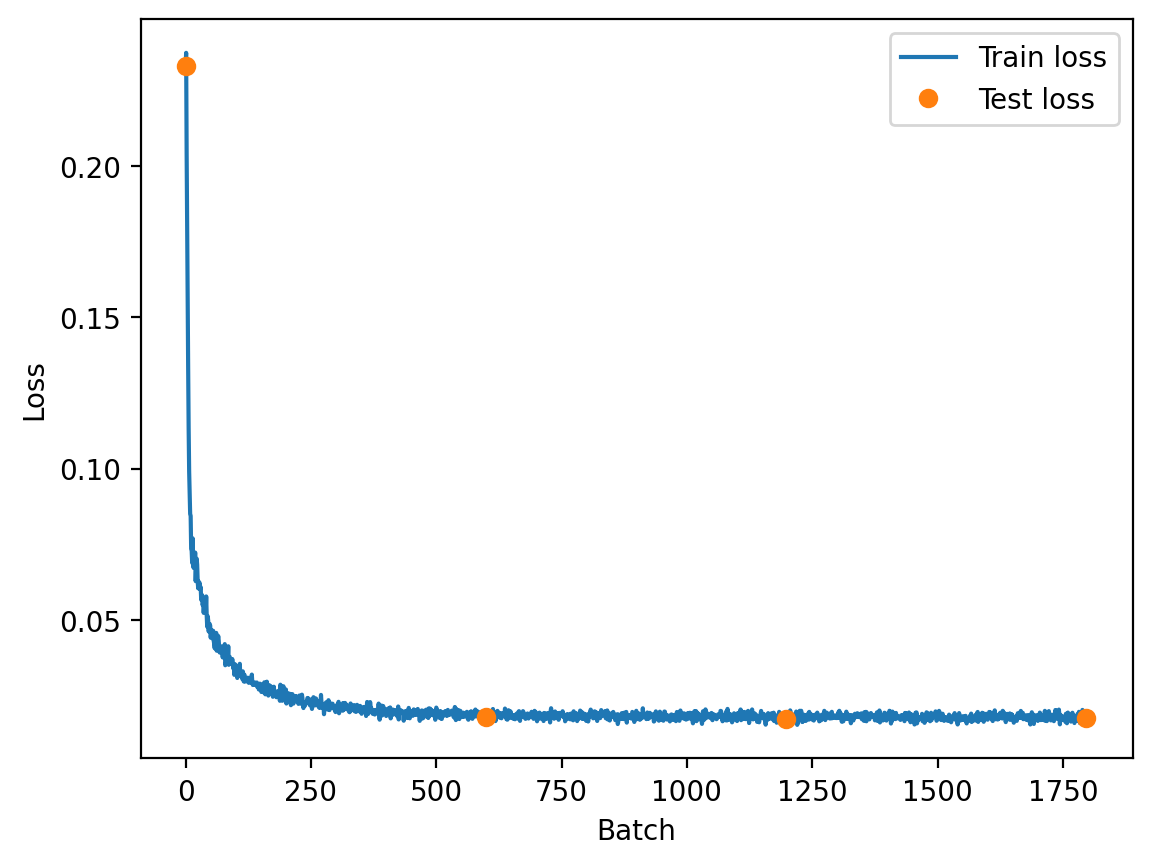

Learning rate: 0.01 Test loss: 0.017654142593964934


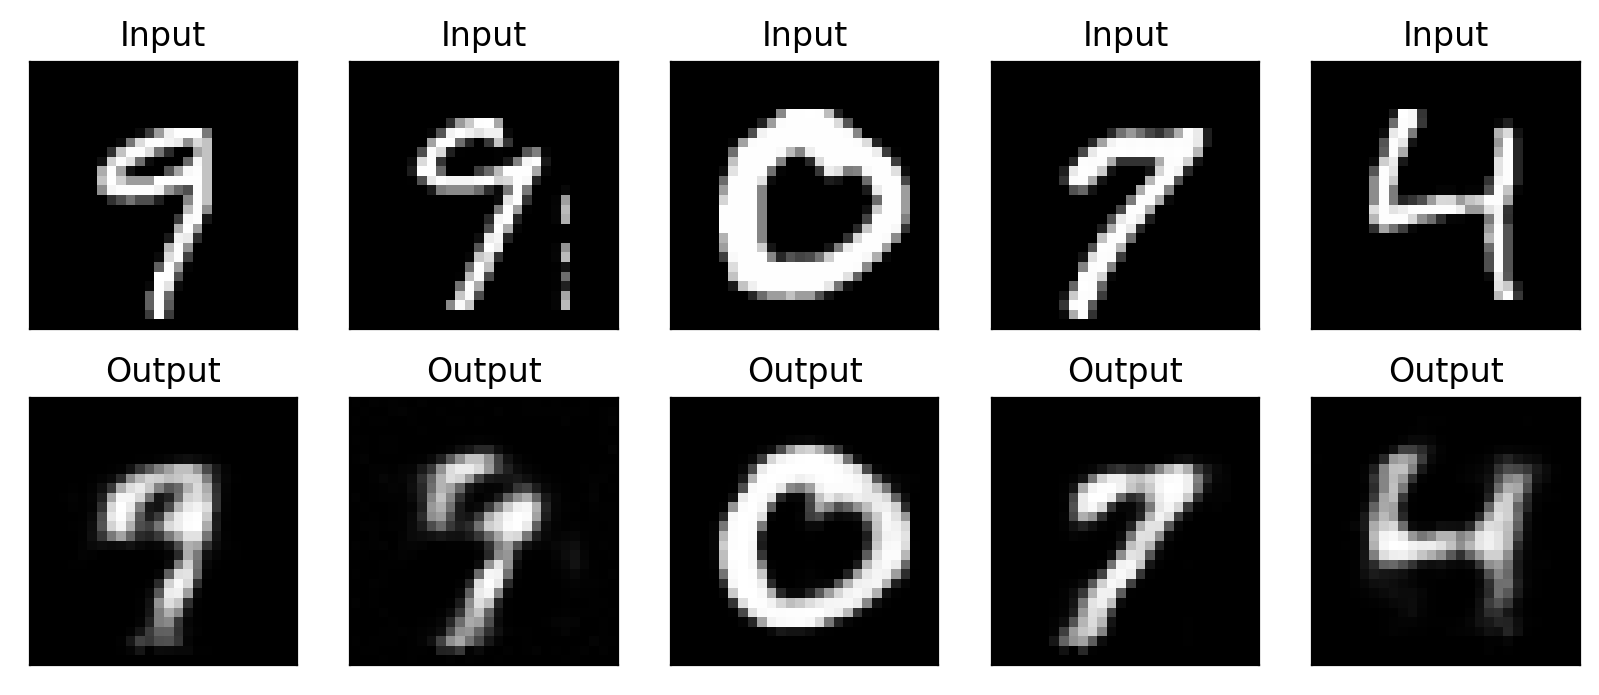

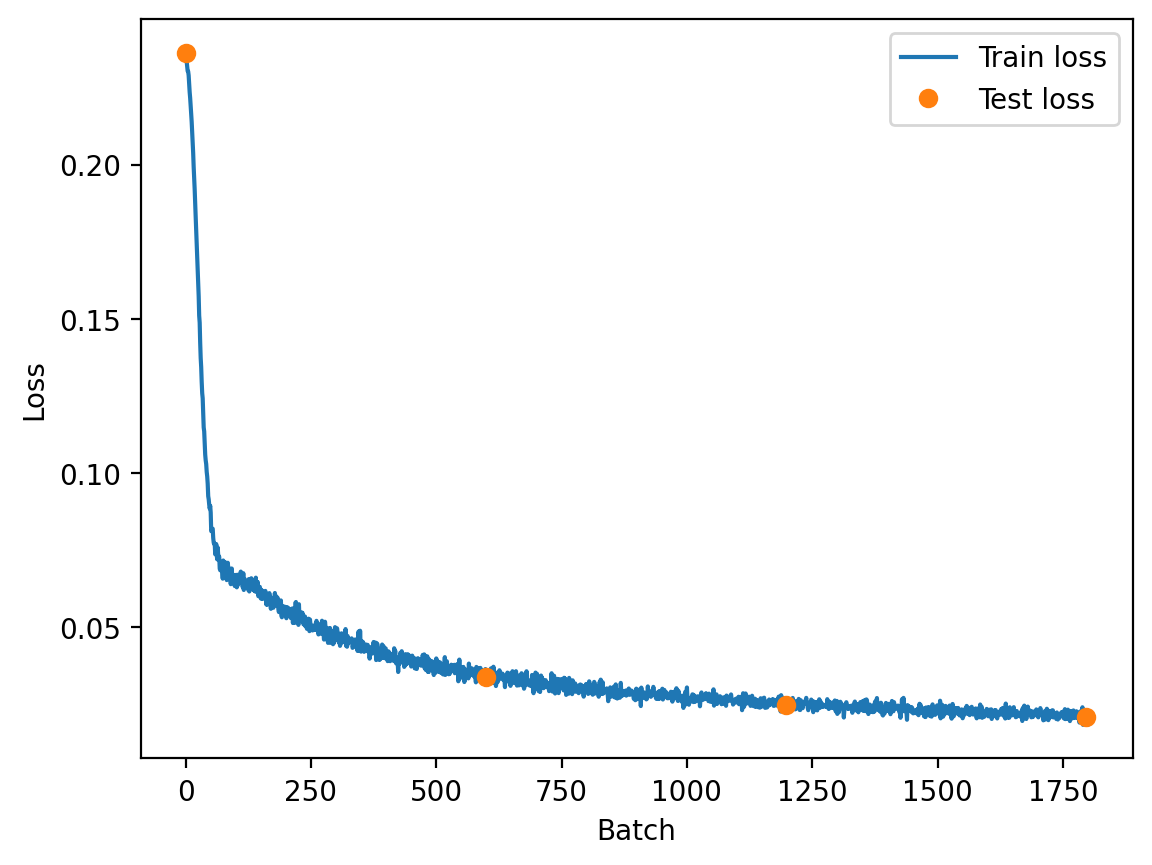

Learning rate: 0.001 Test loss: 0.021006480697542428


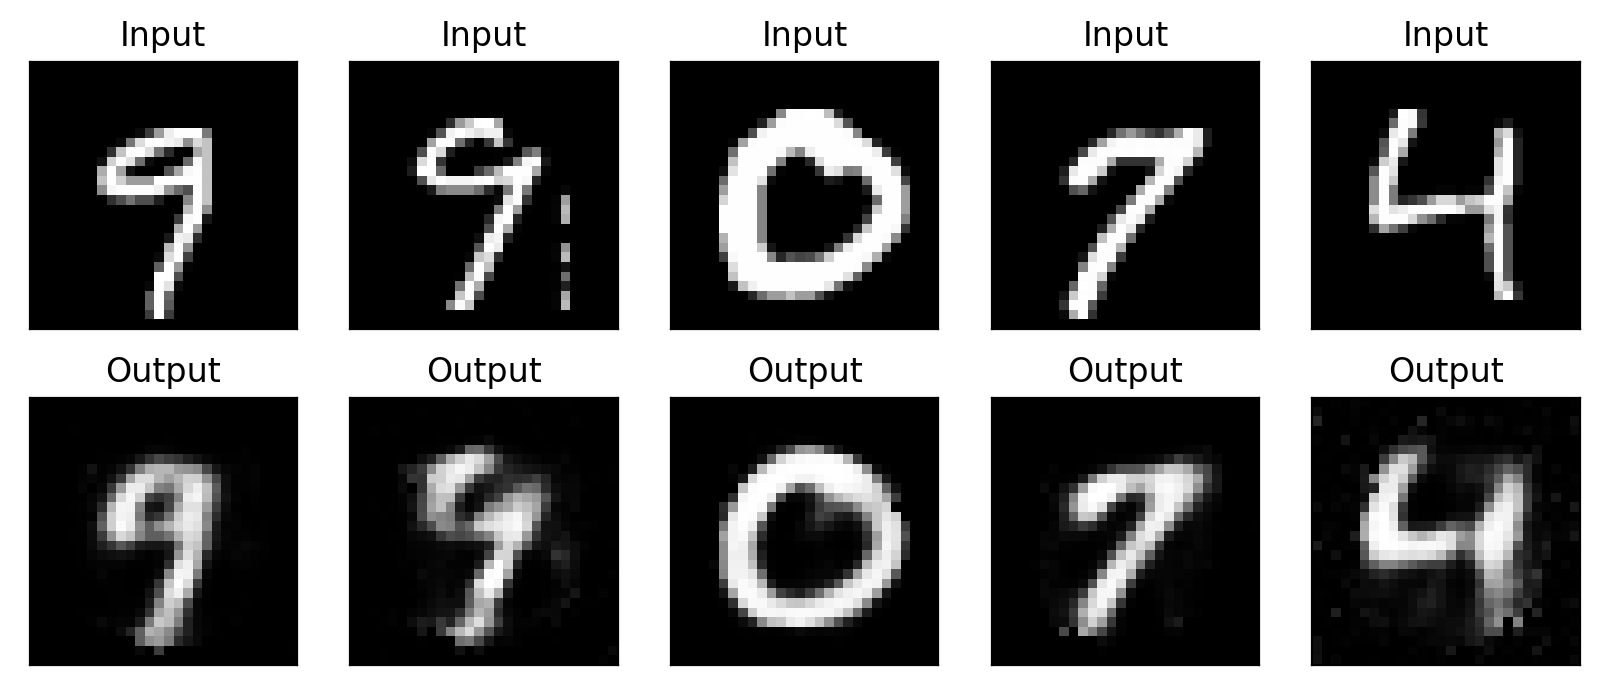

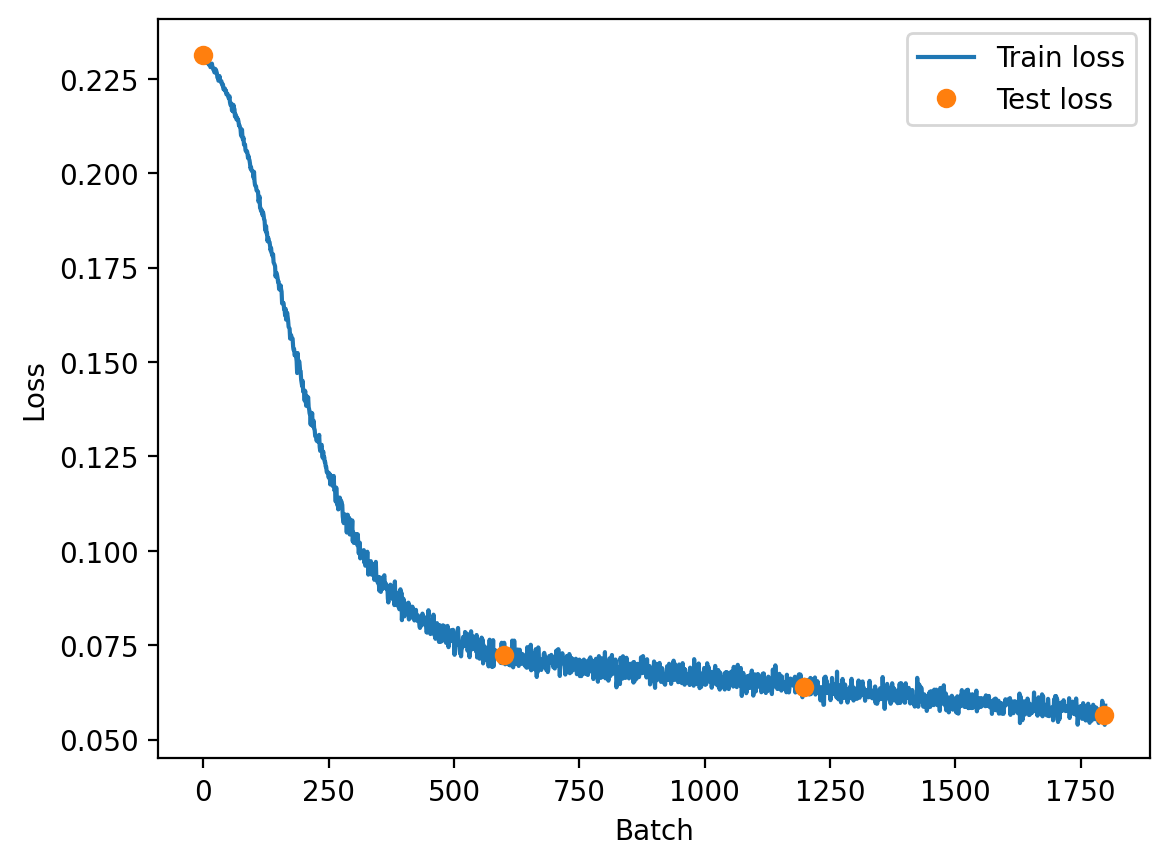

Learning rate: 0.0001 Test loss: 0.05661922603845596


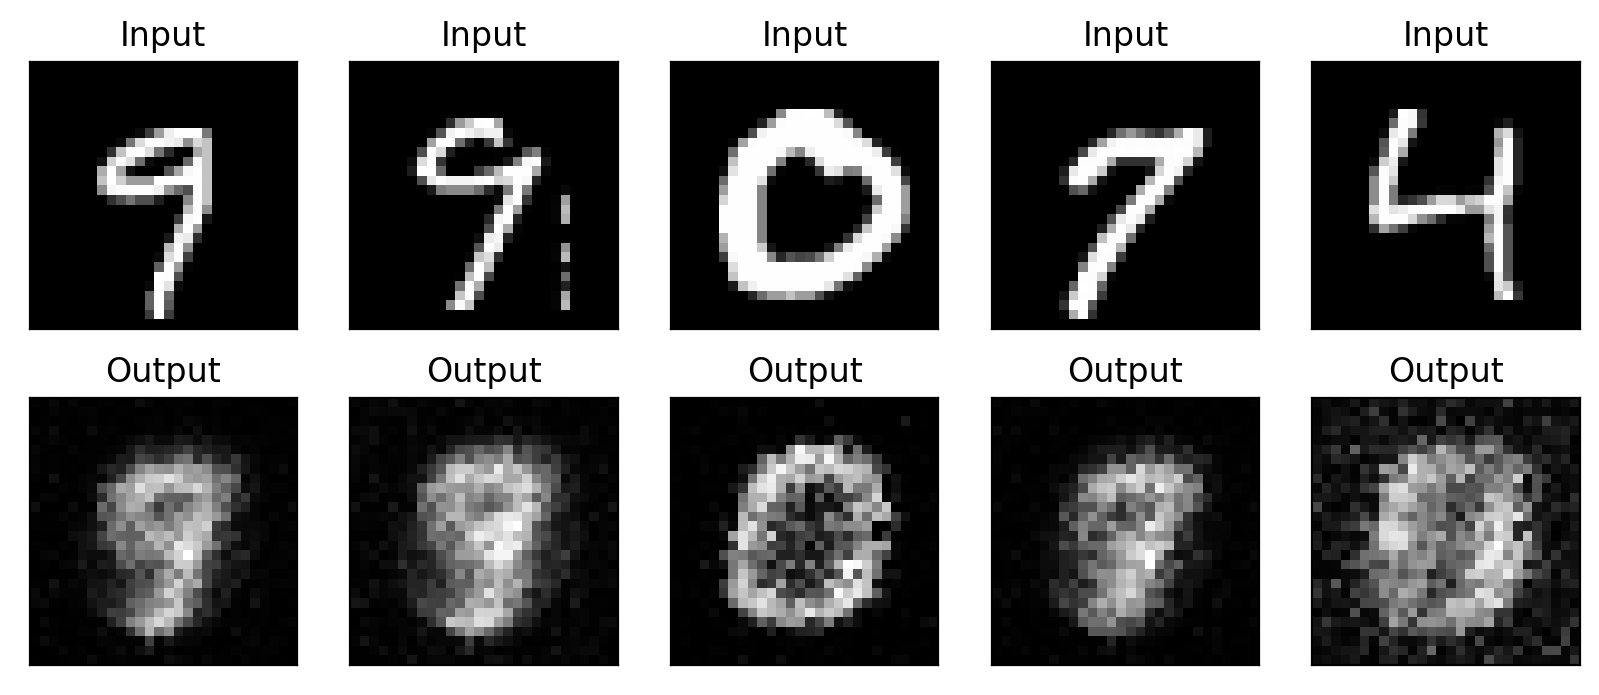

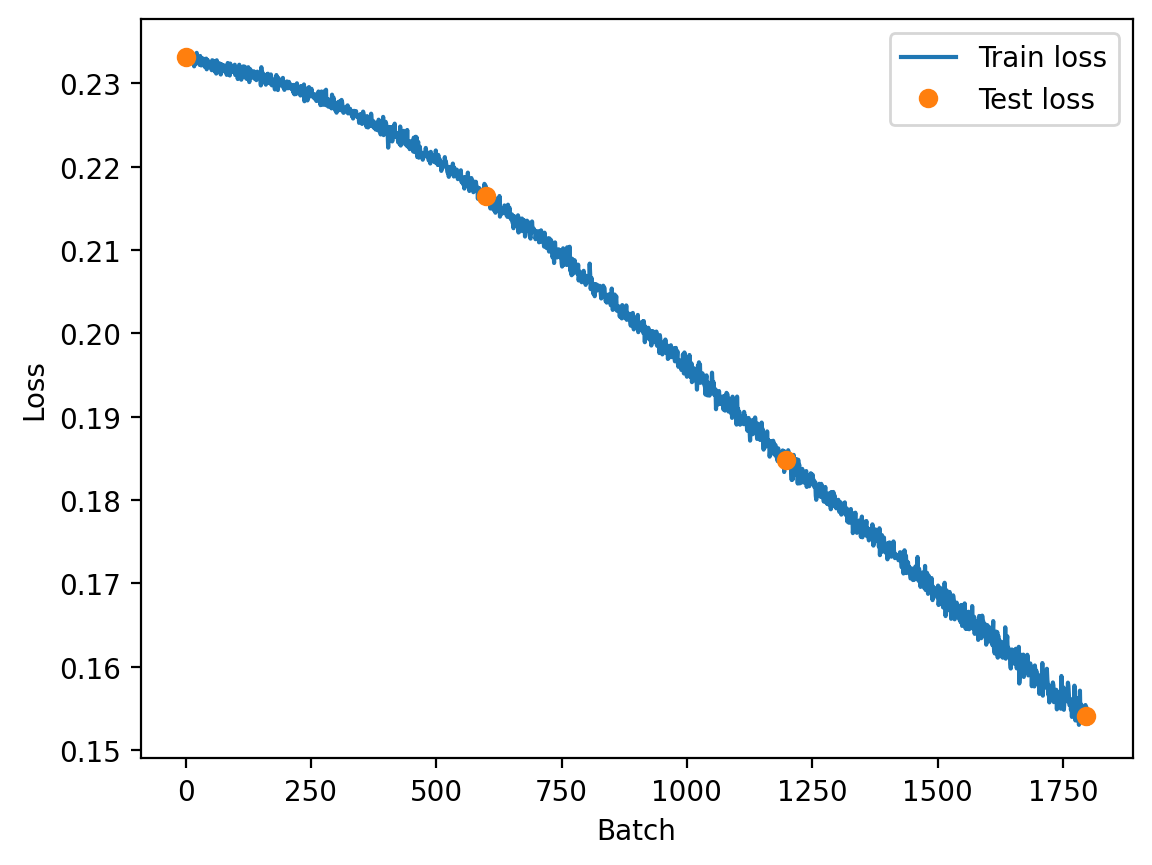

Learning rate: 1e-05 Test loss: 0.1540372884273529


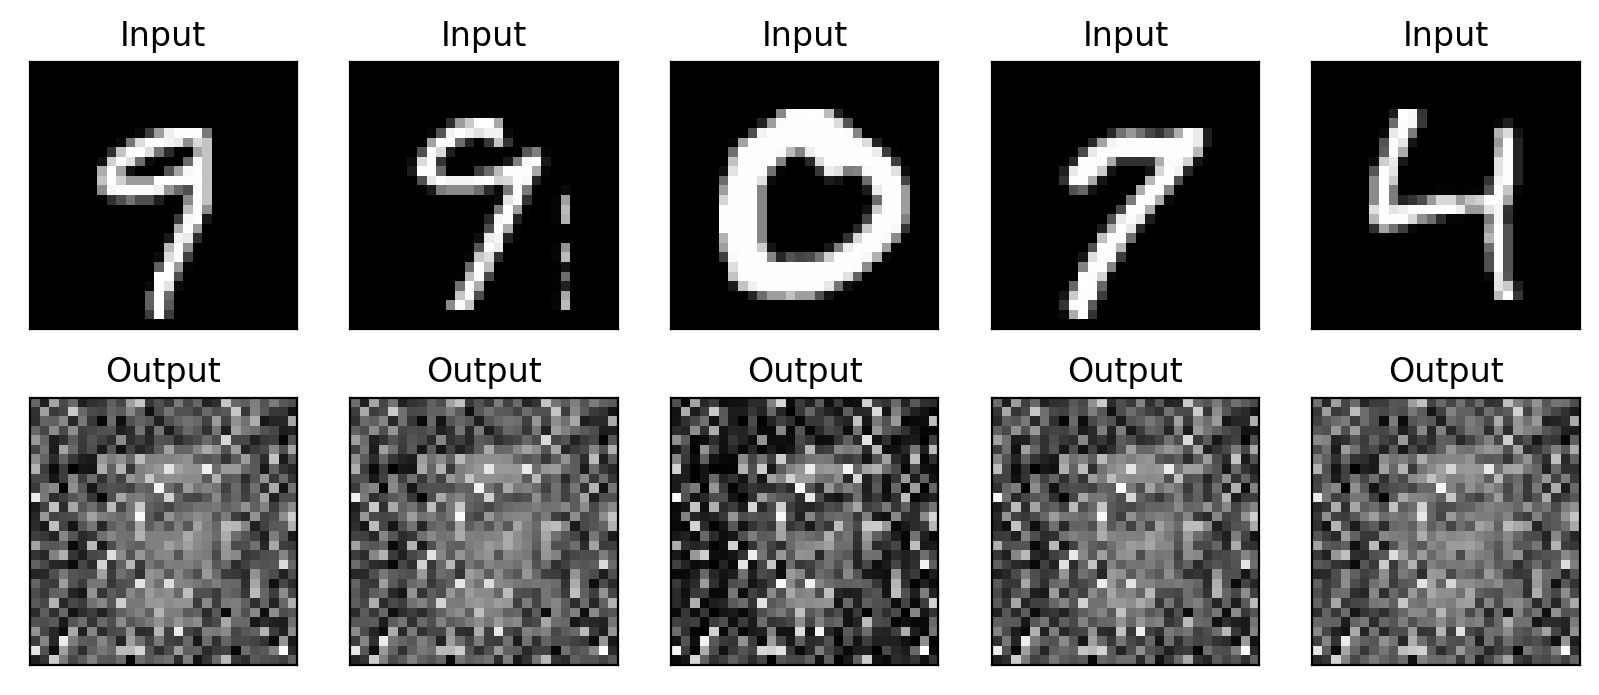

In [ ]:
for lr in [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]:
    AE = AElin(hdim=20)
    optimizer = optim.Adam(AE.parameters(), lr=lr)
    _, loss_eval = AE_train(
        AE, lossAE, optimizer, epochs=3, plot=True, verbose=False, freq=100
    )
    print("Learning rate:", lr, "Test loss:", loss_eval[-1])
    plot_result(AE)

# 4 Use the AE as a denoising model

We will see in this section how we can use the a AutoEncoder a denoising model. First, we define a function that will add noise to the images and plot the reconstruction.

In [ ]:
def plot_denoising(model):
    images = first_batch_images[:1]
    sigmas = [1e-2, 2e-2, 5e-2, 1e-1, 3e-1, 5e-1]
    plt.figure(figsize=(8, 4))
    for k, sigma in enumerate(sigmas):

        plt.subplot(3, len(sigmas), k + 1)
        if k == 0:
            plt.ylabel("Original", fontsize=14)
        plt.imshow(images.cpu().numpy().reshape(28, 28), cmap="gray")
        plt.xticks([])
        plt.yticks([])

        noise = torch.randn(1, 1, 28, 28) * sigma
        plt.subplot(3, len(sigmas), k + 1 + len(sigmas))
        if k == 0:
            plt.ylabel("Noisy", fontsize=14)
        plt.imshow((noise + images).cpu().numpy().reshape(28, 28), cmap="gray")
        plt.title(f"noise: {sigma:.0e}")
        plt.xticks([])
        plt.yticks([])

        plt.subplot(3, len(sigmas), k + 1 + 2 * len(sigmas))
        if k == 0:
            plt.ylabel("Reconstructed", fontsize=14)
        plt.imshow(
            model((images + noise)).cpu().detach().numpy().reshape(28, 28), cmap="gray"
        )
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.show()

Compare the performance of two different models.

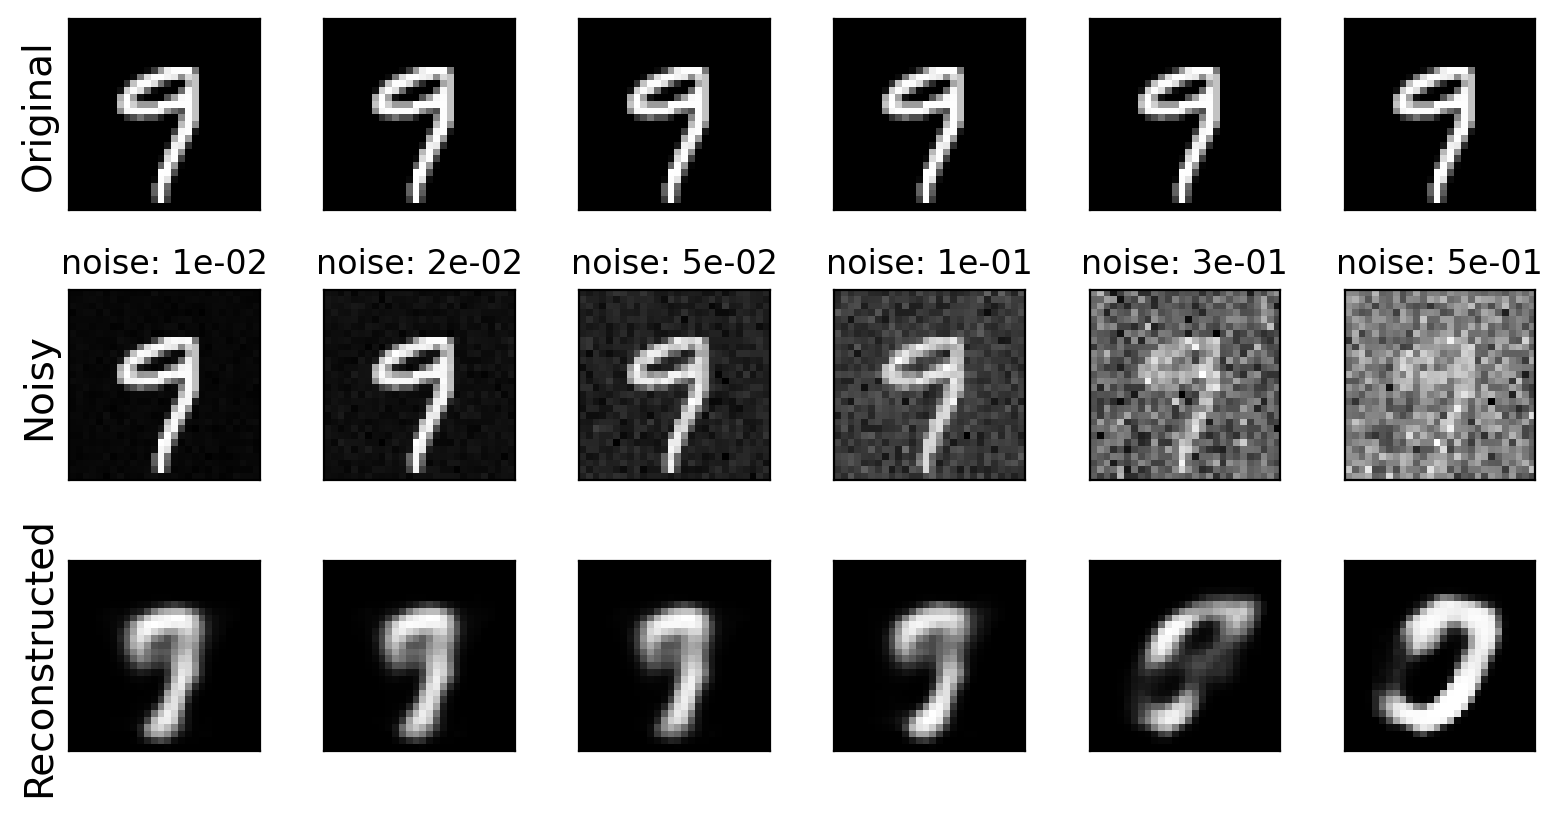

In [ ]:
AE = AElin(hdim=10)
optimizer = optim.Adam(AE.parameters(), lr=1e-2)
AE_train(AE, lossAE, optimizer, epochs=10, plot=False, verbose=False, freq=100)
plot_denoising(AE)

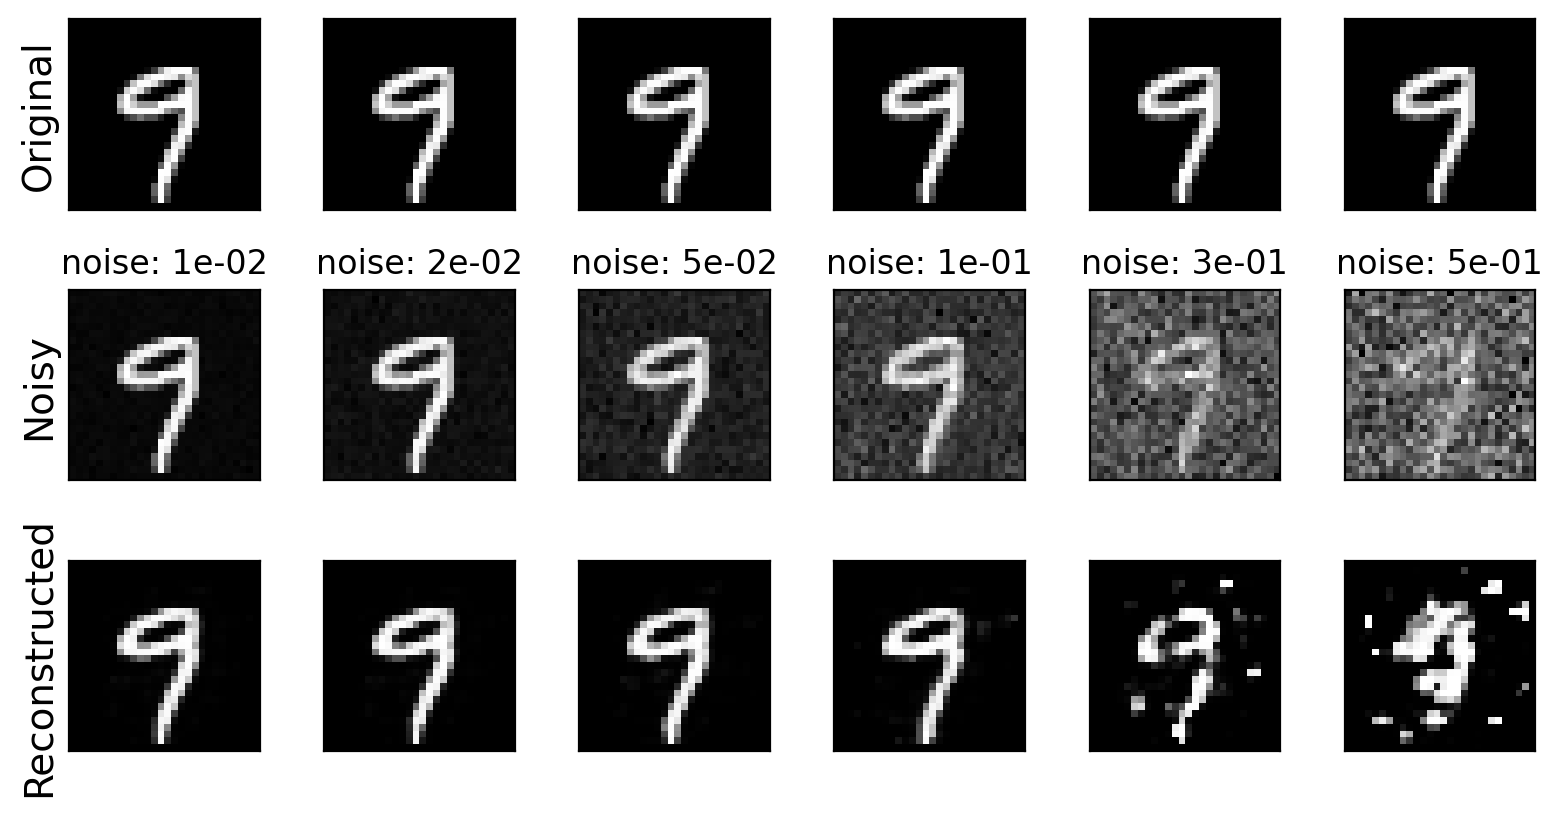

In [ ]:
AE = AElin(hdim=100)
optimizer = optim.Adam(AE.parameters(), lr=1e-2)
AE_train(AE, lossAE, optimizer, epochs=10, plot=False, verbose=False, freq=100)
plot_denoising(AE)

<font color='blue'>(BONUS) TODO:</font> 
- Propose a new training procedure to train the model as a denoising model.

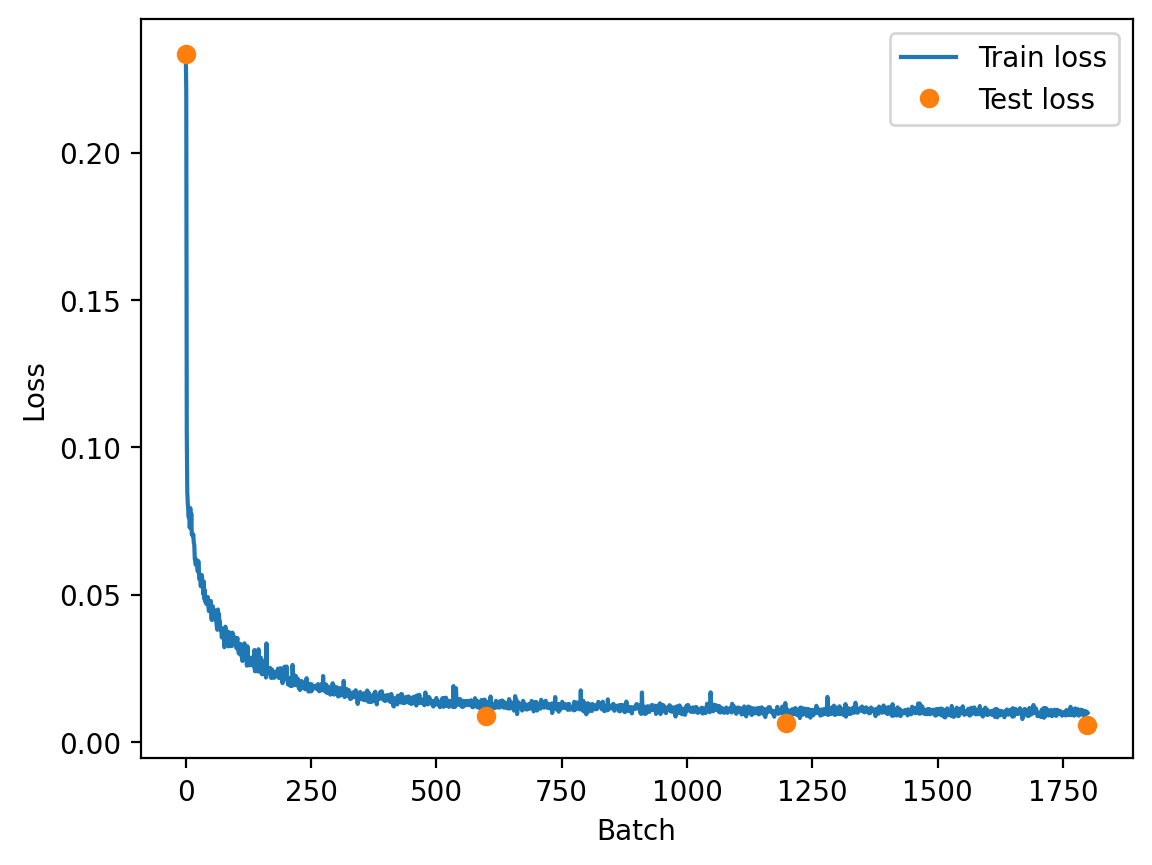

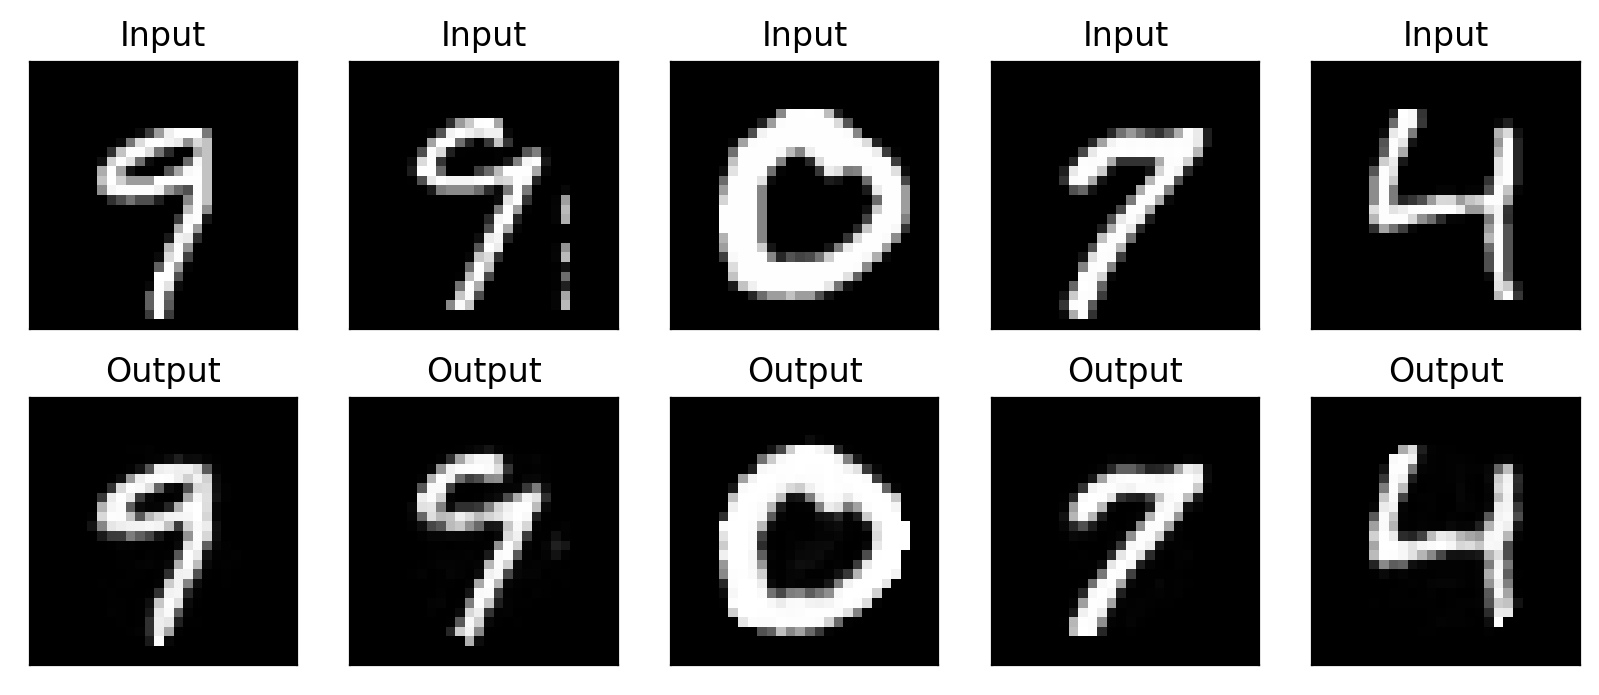

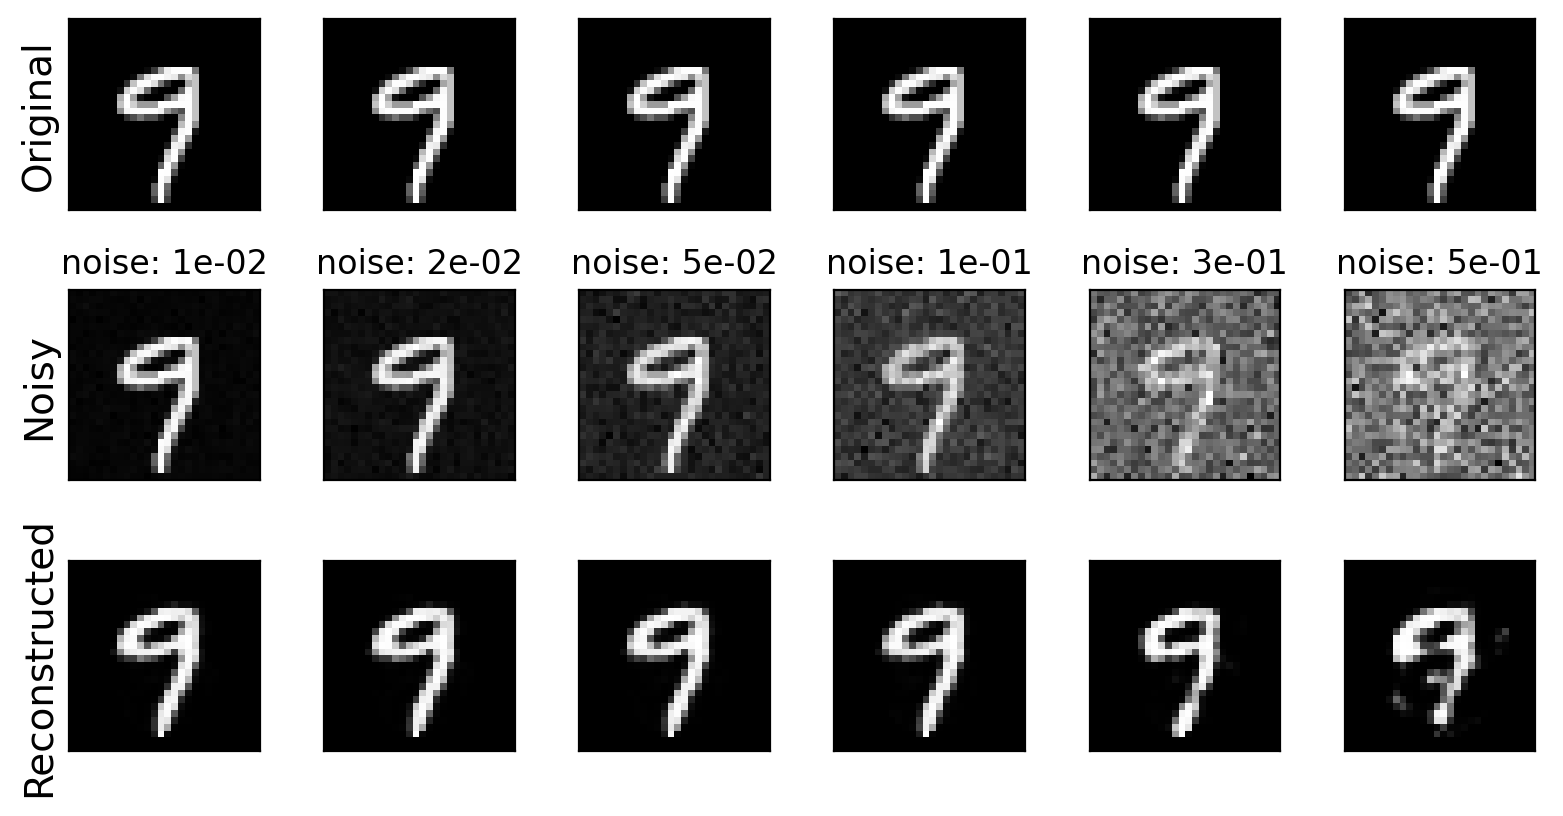

In [ ]:
def AE_train_denoising(
    model, criterion, optimizer, epochs=30, plot=True, verbose=False, freq=10
):
    """AE_train for denoising task
    Train the model
    Input:
        - model: the model to train
        - criterion: the loss function
        - optimizer: the optimization algorithm
        - epochs: the number of epochs
        - plot: if True, plot the train and test losses
        - verbose: if True, print the losses
        - freq: frequency of printing the losses
    Output:
        - train_losses: the train losses
        - test_losses: the test losses
    """
    noise_levels = [1e-2, 2e-2, 5e-2, 1e-1, 3e-1, 5e-1]
    noise_levels = torch.tensor(noise_levels)
    if verbose:
        print("Start training...")
    train_losses = []
    test_losses = [AE_eval(model, criterion)]
    for e in range(epochs):
        for batch_idx, (images, labels) in enumerate(train_loader):
            images = images
            noise_levels_batch = torch.randint(0, len(noise_levels), (images.size(0),))
            images_noisy = (
                images
                + torch.randn_like(images)
                * noise_levels[noise_levels_batch, None, None, None]
            )
            optimizer.zero_grad()
            recons = model(images_noisy)
            loss = criterion(recons, images)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
            if verbose and batch_idx % freq == 0:
                print("Epoch %d, Batch %d, loss: %.4f" % (e, batch_idx, loss.item()))
        test_loss = AE_eval(model, criterion)
        test_losses.append(test_loss)
        if verbose:
            print("\t Epoch %d/%d, Test loss: %.4f" % (e + 1, epochs, test_loss))
    if plot:
        plt.plot(train_losses, label="Train loss")
        plt.plot(
            [e * batch_idx for e in range(e + 2)],
            test_losses,
            label="Test loss",
            marker="o",
            linewidth=0.0,
        )
        plt.legend()
        plt.xlabel("Batch")
        plt.ylabel("Loss")
        plt.show()
    return train_losses, test_losses


AE = AElin(hdim=100)
optimizer = optim.Adam(AE.parameters(), lr=1e-2)
AE_train_denoising(AE, lossAE, optimizer, epochs=3, plot=True, verbose=False, freq=100)
plot_result(AE)
plot_denoising(AE)

# 5 Anomaly detection

Autoencoders can learn to represent the data in a latent representation space and to reconstruct the data from this compressed representation. One possible application of AE is Anomaly detection. The method is simple: 
- if you encode and decode an image similar to the training data, the reconstruction loss should be low, while 
- if you do the same with an image that differs from the training set, the loss should be higher. 

We will use a strong model:

In [ ]:
AE = AElin(hdim=100)
optimizer = optim.Adam(AE.parameters(), lr=1e-2)
AE_train(AE, lossAE, optimizer, epochs=5, plot=False, verbose=False, freq=100)

To test compare data dstribution we can compare:
- the loss on the training data 
- the loss on the training with different anomalies
    - Transpositions
    - Artifacts
    - Mixing

In [ ]:
def make_anomaly(input_data, mode="transpose"):
    """make_anomaly
    Detect anomalies in the input data using the model
    Input:
        - input_data: the input data
        - mode: the mode for the anomaly detection among ['transpose', 'artifacts', 'mixing']
    Output:
        - anomalies: the pertubed images
    """
    if mode == "transpose":
        anomalies = input_data.clone()
        anomalies = anomalies.permute(0, 1, 3, 2)

    elif mode == "artifacts":
        anomalies = input_data.clone()
        anomalies[:, :, 10:20, 10:20] = 1
    elif mode == "mixing":
        anomalies = input_data.clone()
        anomalies[:, :, 10:15, 10:15] = input_data[:, :, 15:20, 15:20]
        anomalies[:, :, 15:20, 15:20] = input_data[:, :, 10:15, 10:15]
        anomalies[:, :, 10:15, 15:20] = input_data[:, :, 15:20, 10:15]
        anomalies[:, :, 15:20, 10:15] = input_data[:, :, 10:15, 15:20]
    return anomalies


def plot_anomalies(model, mode="transpose"):
    anomalies = make_anomaly(first_batch_images, mode=mode)
    recons = model(first_batch_images)
    recons_a = model(anomalies)

    plt.figure(figsize=(8, 5))
    for i in range(5):
        plt.subplot(4, 5, i + 1)
        image = first_batch_images[i].cpu().numpy().reshape(28, 28)
        if i == 0:
            plt.ylabel("Original", fontsize=14)
        plt.imshow(image, cmap="gray")
        plt.xticks([])
        plt.yticks([])
        plt.subplot(4, 5, i + 6)
        recon = recons[i].cpu().detach().numpy().reshape(28, 28)
        if i == 0:
            plt.ylabel("Recons", fontsize=14)
        plt.title(f"MSE: {np.linalg.norm(image - recon):.2f}", fontsize=14)
        plt.imshow(recon, cmap="gray")
        plt.xticks([])
        plt.yticks([])
        plt.subplot(4, 5, i + 11)
        anomaly = anomalies[i].detach().numpy().reshape(28, 28)
        if i == 0:
            plt.ylabel("Anomaly", fontsize=14)
        plt.imshow(anomaly, cmap="gray")
        plt.xticks([])
        plt.yticks([])
        plt.subplot(4, 5, i + 16)
        recon = recons_a[i].cpu().detach().numpy().reshape(28, 28)
        if i == 0:
            plt.ylabel("Recons", fontsize=14)
        plt.title(f"MSE: {np.linalg.norm(anomaly - recon):.2f}", fontsize=14)
        plt.imshow(recon, cmap="gray")
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()

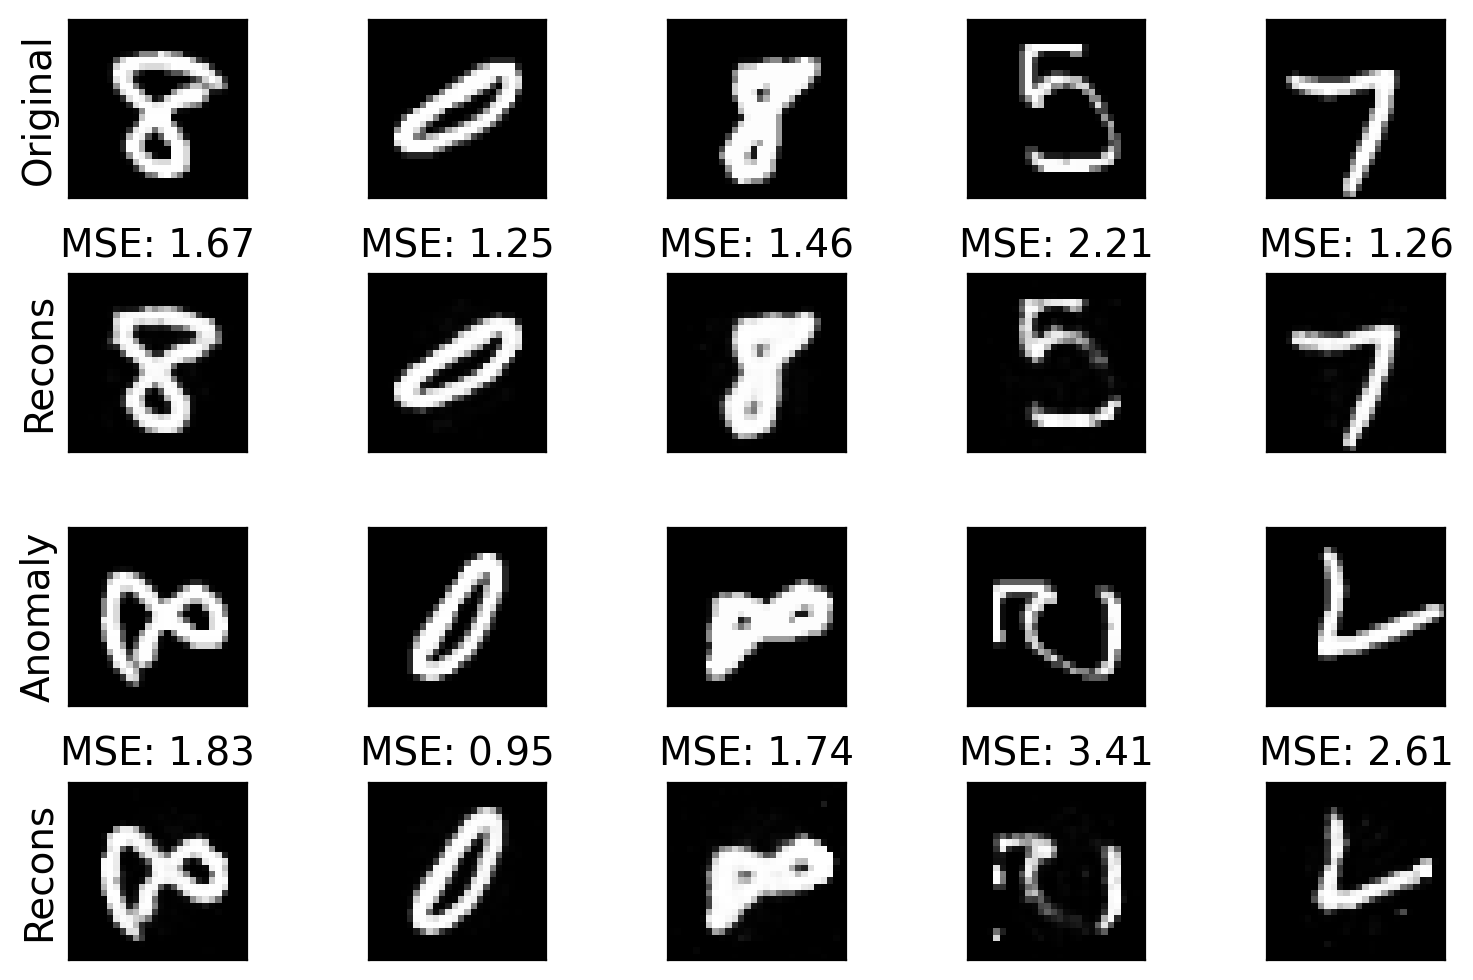

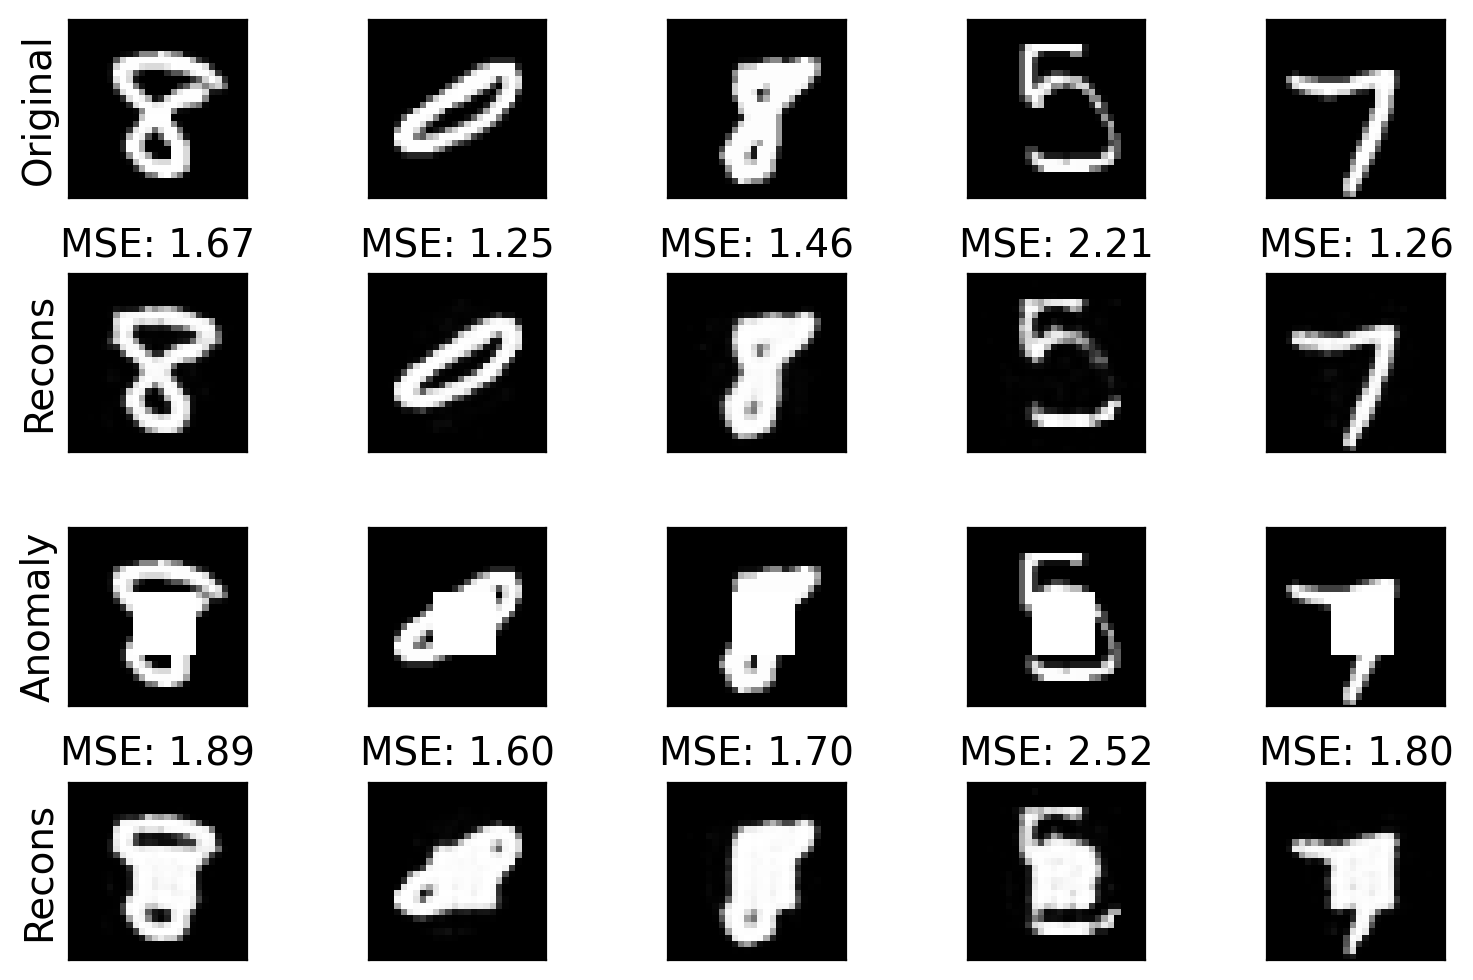

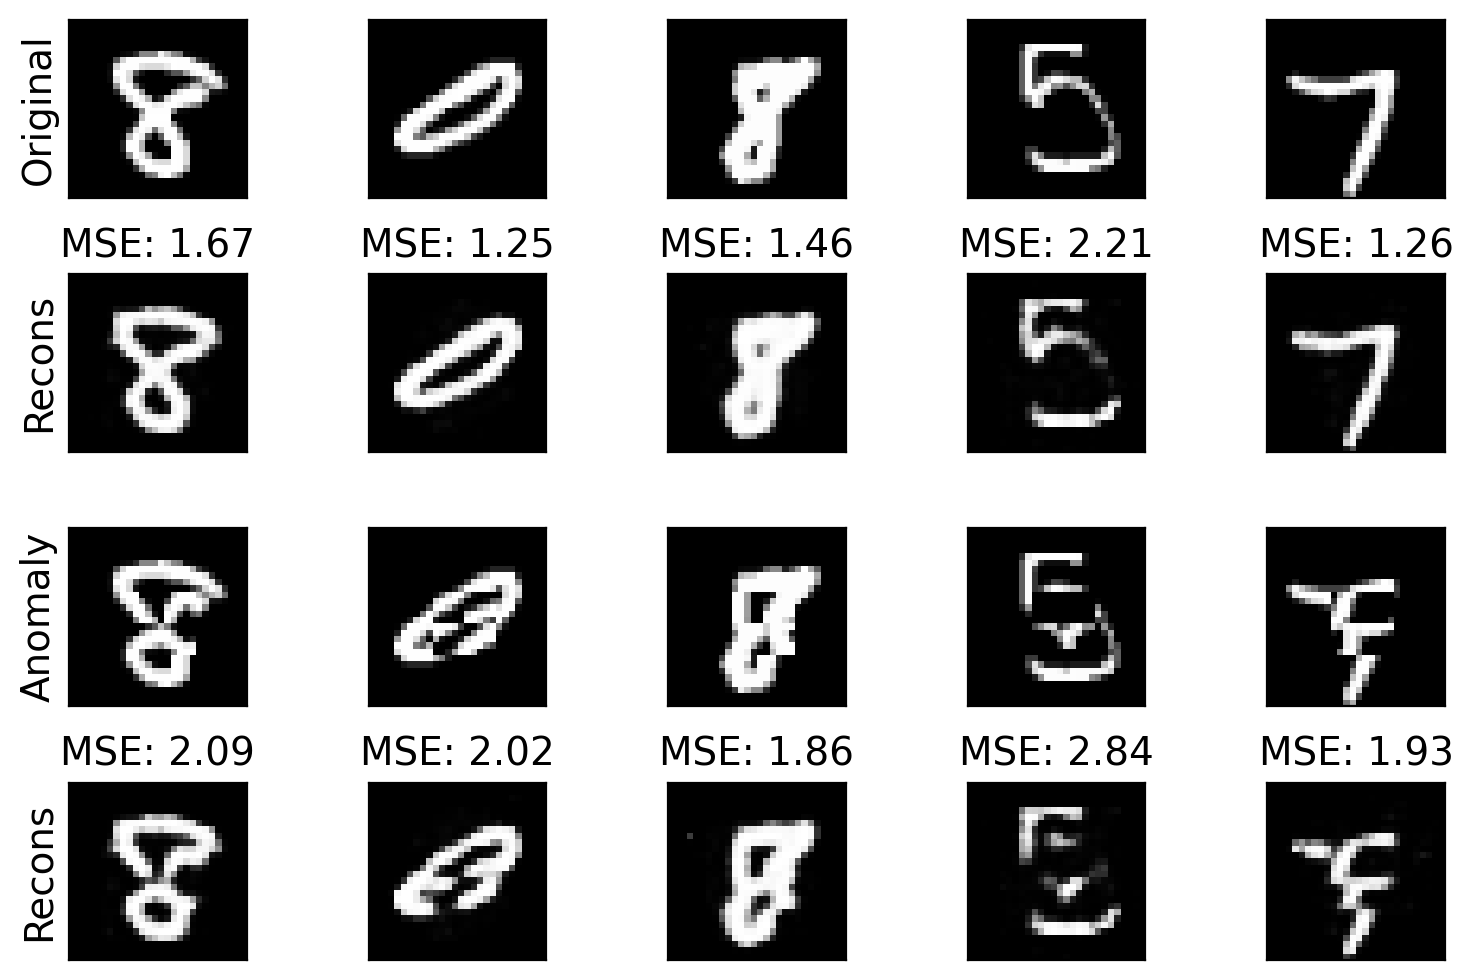

In [ ]:
plot_anomalies(AE, mode="transpose")
plot_anomalies(AE, mode="artifacts")
plot_anomalies(AE, mode="mixing")

**TODO**: 
- code a function that compute these two histograms and plot these
- check if the histogram differs for the different type of anomalies

In [ ]:
def detect_anomalies(model, loader, mode="transpose"):
    """detect_anomalies
    Plot the histogram of the MSE of the anomalies on the test  set
    Input:
        - model: the trained model
        - mode: the mode for the anomaly detection among ['transpose', 'artifacts', 'mixing']
    Output:
        - None
    """
    mse = nn.MSELoss(reduction="none")
    mse_images = []
    mse_anomalies = []
    for images, _ in loader:
        images = images
        anomalies = make_anomaly(images, mode=mode)
        recons = model(images)
        recons_a = model(anomalies)
        mse_images.append(
            mse(recons, images).sum(dim=3).sum(dim=2).cpu().detach().numpy()
        )
        mse_anomalies.append(
            mse(recons_a, anomalies).sum(dim=3).sum(dim=2).cpu().detach().numpy()
        )
    plt.figure(figsize=(4, 4))
    mse_images = np.concatenate(mse_images)
    h1 = plt.hist(mse_images, bins=50, alpha=0.5, label="Images", density=True)
    mse_anomalies = np.concatenate(mse_anomalies)
    h2 = plt.hist(mse_anomalies, bins=50, alpha=0.5, label="Anomalies", density=True)
    plt.legend()
    plt.title(mode)
    plt.show()

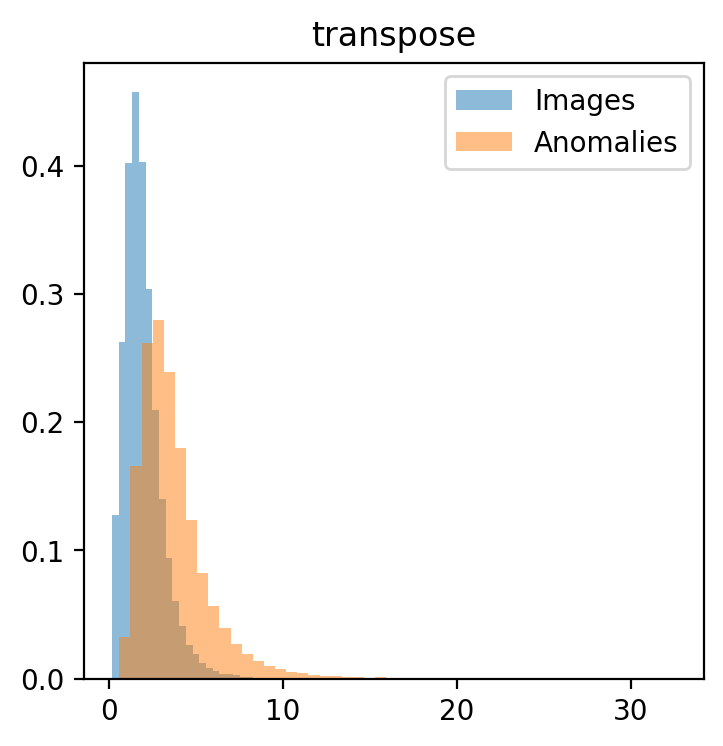

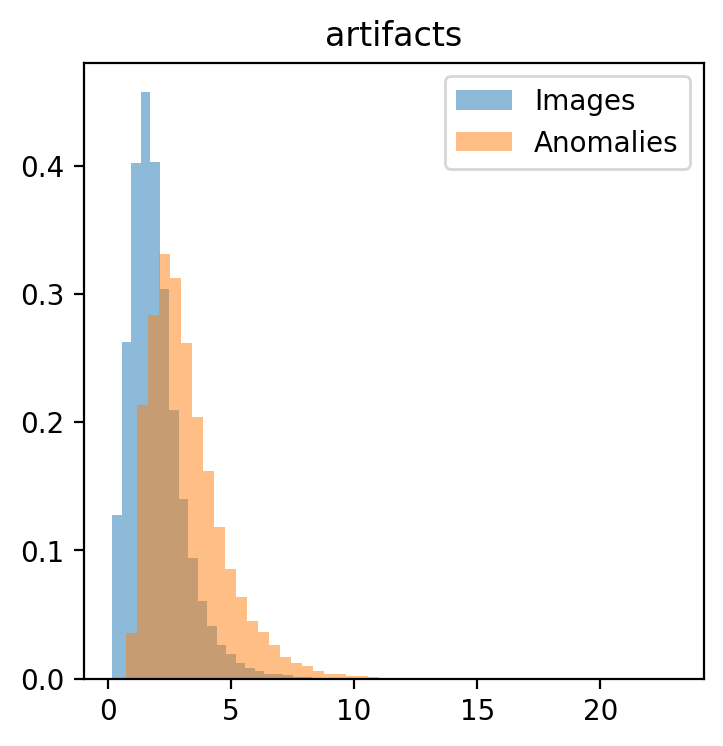

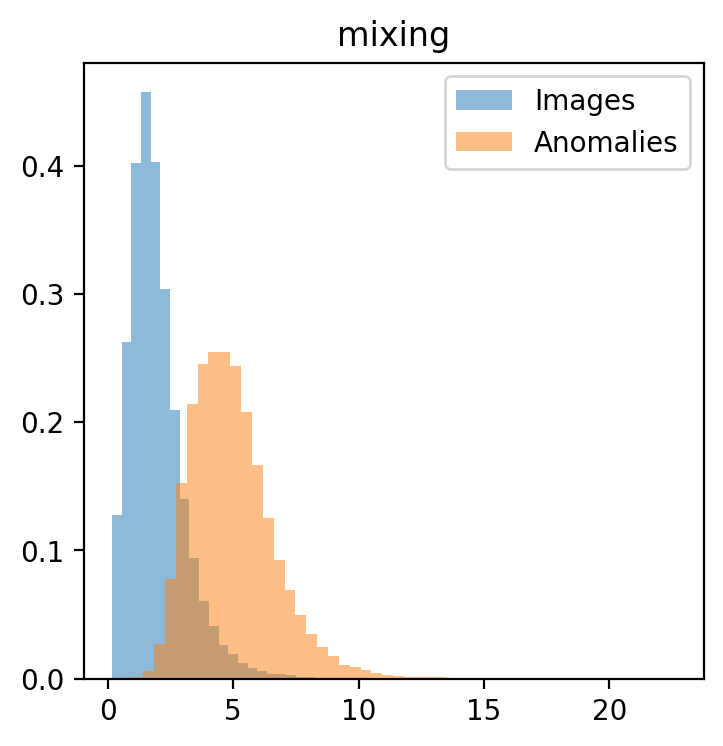

In [ ]:
detect_anomalies(AE, train_loader, mode="transpose")
detect_anomalies(AE, train_loader, mode="artifacts")
detect_anomalies(AE, train_loader, mode="mixing")

# 6 Full connected autoencoder

We can increase the depth of the AE: 
- the encoder is composed of a first linear transformation, followed by a non-linearity (ReLU) and a second linear transformation. 
- the decoder performs the symmetric operations. 

As dimensions we can consider as a first choice : 784 #  256 ==> $h_{dim}=2$ ==> 256 ==> 784. 

**TODO**
- Write the class for such AE and test with the basic configuration (see above). 

In [ ]:
class SimpleAE(nn.Module):
    def __init__(self, hdim1=256, hdim2=2):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, hdim1), nn.ReLU(), nn.Linear(hdim1, hdim2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(hdim2, hdim1), nn.ReLU(), nn.Linear(hdim1, 28 * 28), nn.Sigmoid()
        )

    def encoder_function(self, x):
        x = x.view(x.size(0), -1)
        return self.encoder(x)

    def forward(self, x):
        x = x.reshape(x.size(0), -1)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        decoded = decoded.reshape(x.size(0), 1, 28, 28)
        return decoded

Start training...
Epoch 0, Batch 0, loss: 0.2338
Epoch 0, Batch 100, loss: 0.0746
Epoch 0, Batch 200, loss: 0.0667
Epoch 0, Batch 300, loss: 0.0629
Epoch 0, Batch 400, loss: 0.0615
Epoch 0, Batch 500, loss: 0.0585
	 Epoch 1/10, Test loss: 0.0581
Epoch 1, Batch 0, loss: 0.0610
Epoch 1, Batch 100, loss: 0.0586
Epoch 1, Batch 200, loss: 0.0563
Epoch 1, Batch 300, loss: 0.0607
Epoch 1, Batch 400, loss: 0.0565
Epoch 1, Batch 500, loss: 0.0548
	 Epoch 2/10, Test loss: 0.0549
Epoch 2, Batch 0, loss: 0.0517
Epoch 2, Batch 100, loss: 0.0513
Epoch 2, Batch 200, loss: 0.0543
Epoch 2, Batch 300, loss: 0.0525
Epoch 2, Batch 400, loss: 0.0532
Epoch 2, Batch 500, loss: 0.0513
	 Epoch 3/10, Test loss: 0.0533
Epoch 3, Batch 0, loss: 0.0527
Epoch 3, Batch 100, loss: 0.0551
Epoch 3, Batch 200, loss: 0.0530
Epoch 3, Batch 300, loss: 0.0483
Epoch 3, Batch 400, loss: 0.0520
Epoch 3, Batch 500, loss: 0.0526
	 Epoch 4/10, Test loss: 0.0520
Epoch 4, Batch 0, loss: 0.0491
Epoch 4, Batch 100, loss: 0.0532
Epoch 

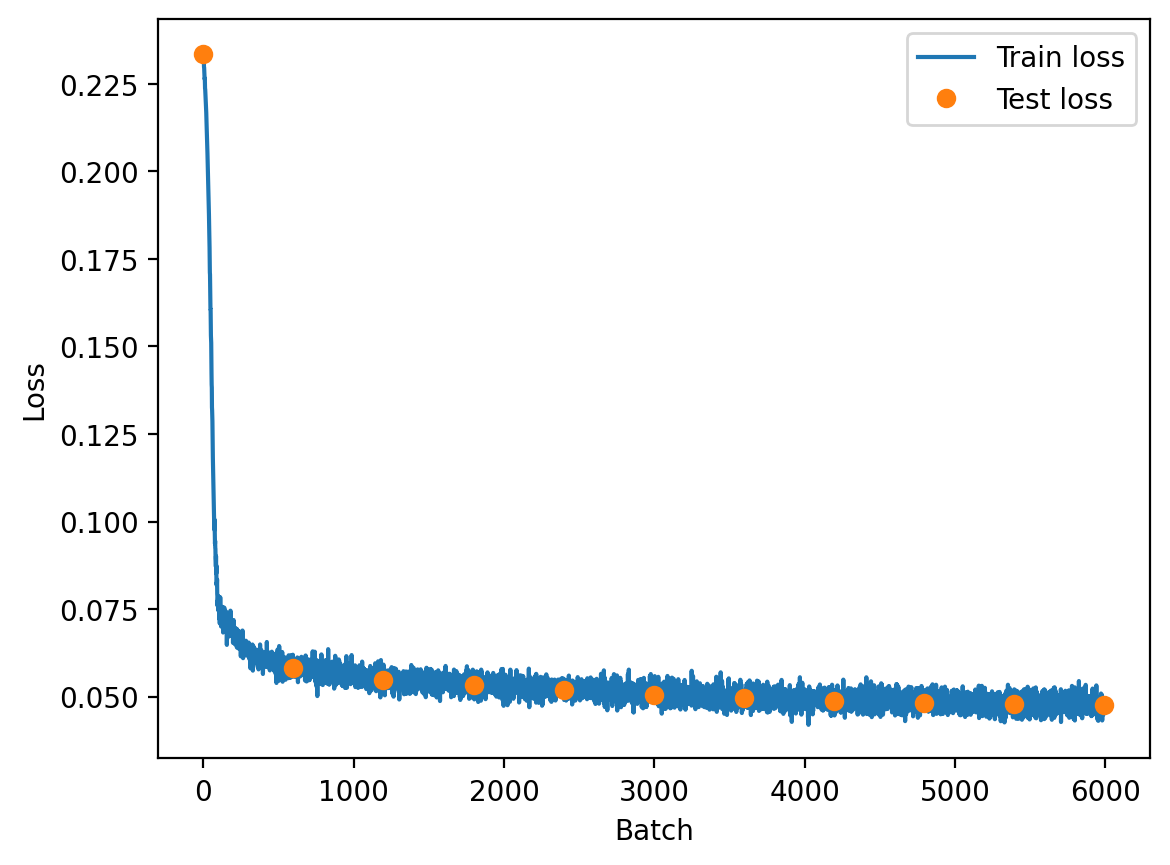

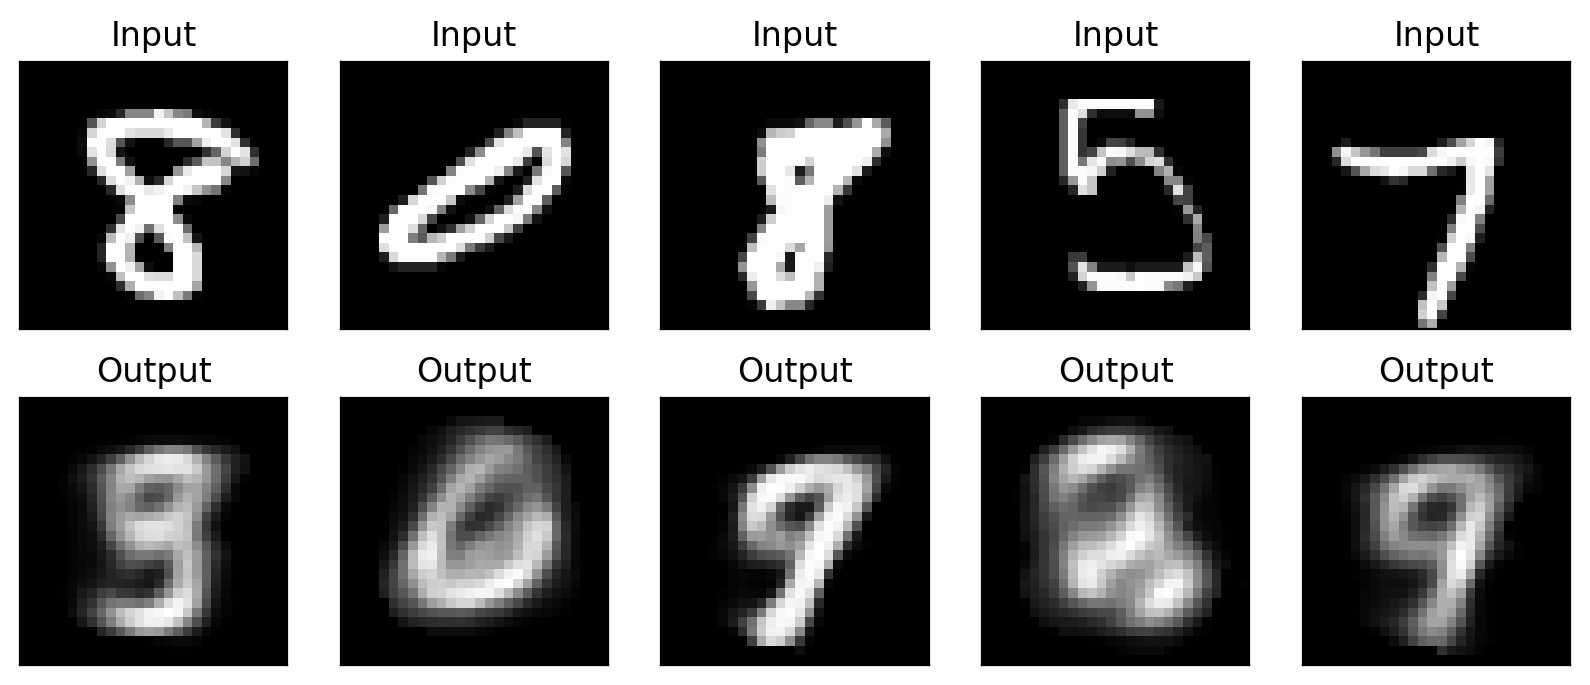

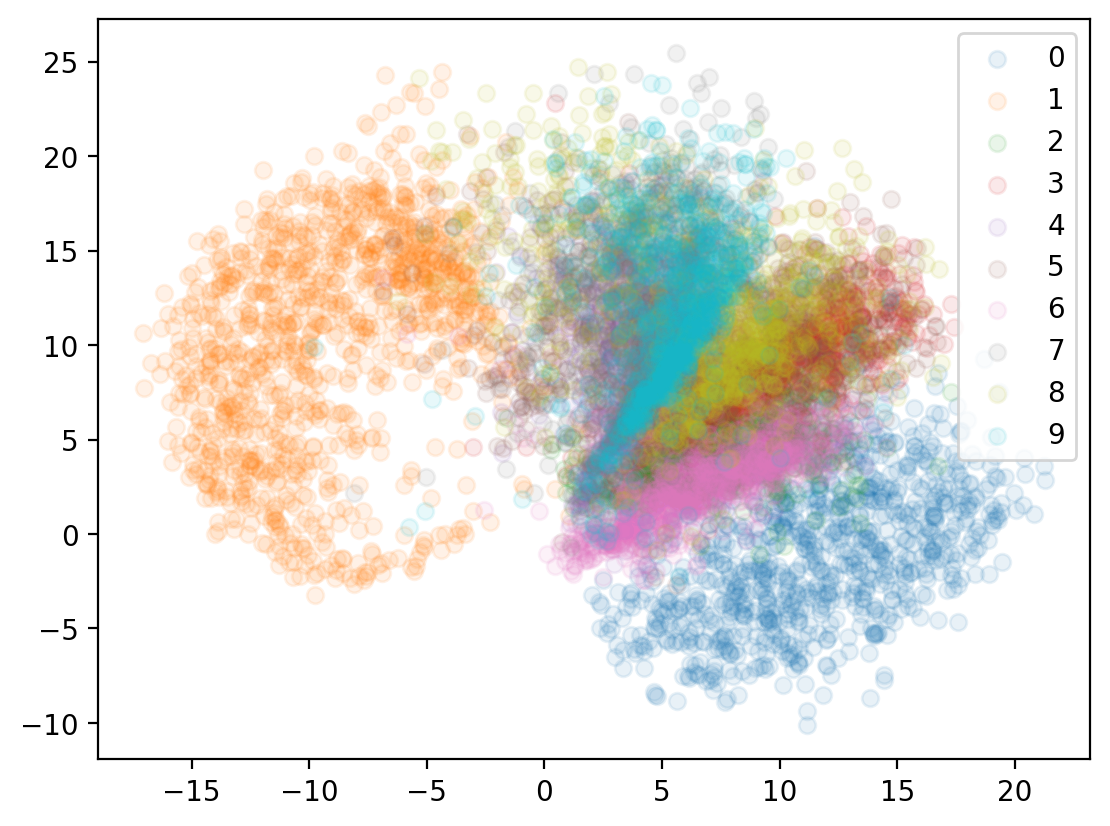

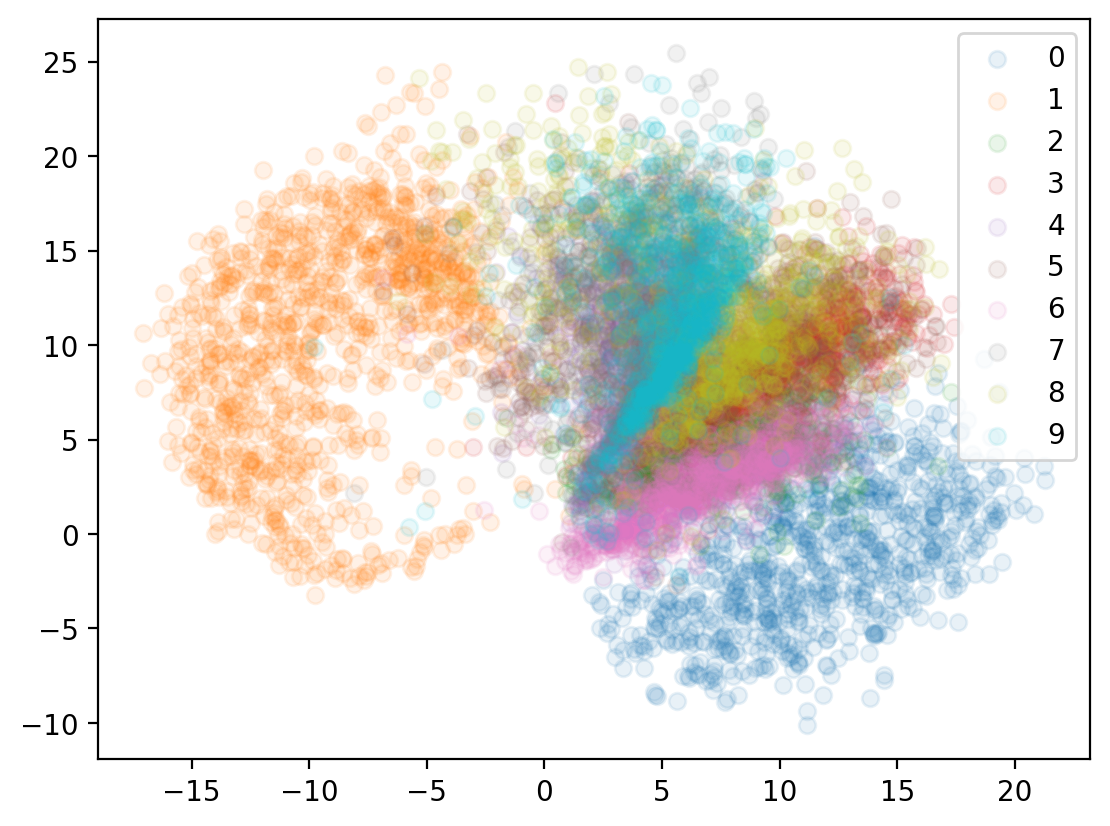

In [ ]:
SAE = SimpleAE(hdim1=256, hdim2=2)
optimizer = optim.Adam(SAE.parameters(), lr=1e-4)
_ = AE_train(SAE, lossAE, optimizer, epochs=10, plot=True, verbose=True, freq=100)
plot_result(SAE)
plotLatentScatter(SAE.encoder_function, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
plotLatentScatter(SAE.encoder_function, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
SAE = SimpleAE(hdim1=256, hdim2=20)
optimizer = optim.Adam(SAE.parameters(), lr=1e-4)
_ = AE_train(SAE, lossAE, optimizer, epochs=10, plot=True, verbose=True, freq=100)
plot_result(SAE)

Test the denoising and anomaly detection.

In [ ]:
plot_anomalies(SAE, mode="transpose")
plot_anomalies(SAE, mode="artifacts")
plot_anomalies(SAE, mode="mixing")

In [ ]:
detect_anomalies(SAE, train_loader, mode="transpose")
detect_anomalies(SAE, train_loader, mode="artifacts")
detect_anomalies(SAE, train_loader, mode="mixing")

# 7 Convolutional Autoencoder

**TODO**:
Implement a CNN Autoencoder with the following architecture:
- Encoder:
    - Conv2d(1, 16, kernel_size=3, stride=2, padding=1) ==> ReLU ==> Conv2d(16, 32, kernel_size=3, stride=2, padding=1) ==> ReLU ==> Conv2d(32, $h_{dim}$, kernel_size=7)
- Decoder:
    - ConvTranspose2d($h_{dim}$, 32, kernel_size=7) ==> ReLU ==> ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1) ==> ReLU ==> ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1) ==> Sigmoid

In [12]:
class ConvAE(nn.Module):
    def __init__(self, hdim=2):
        super().__init__()
        input_shape = (1, 28, 28)
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32 * 7 * 7, hdim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(hdim, 32 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (32, 7, 7)),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

    def encoder_function(self, x):
        return self.encoder(x)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

Number of parameters: 17411


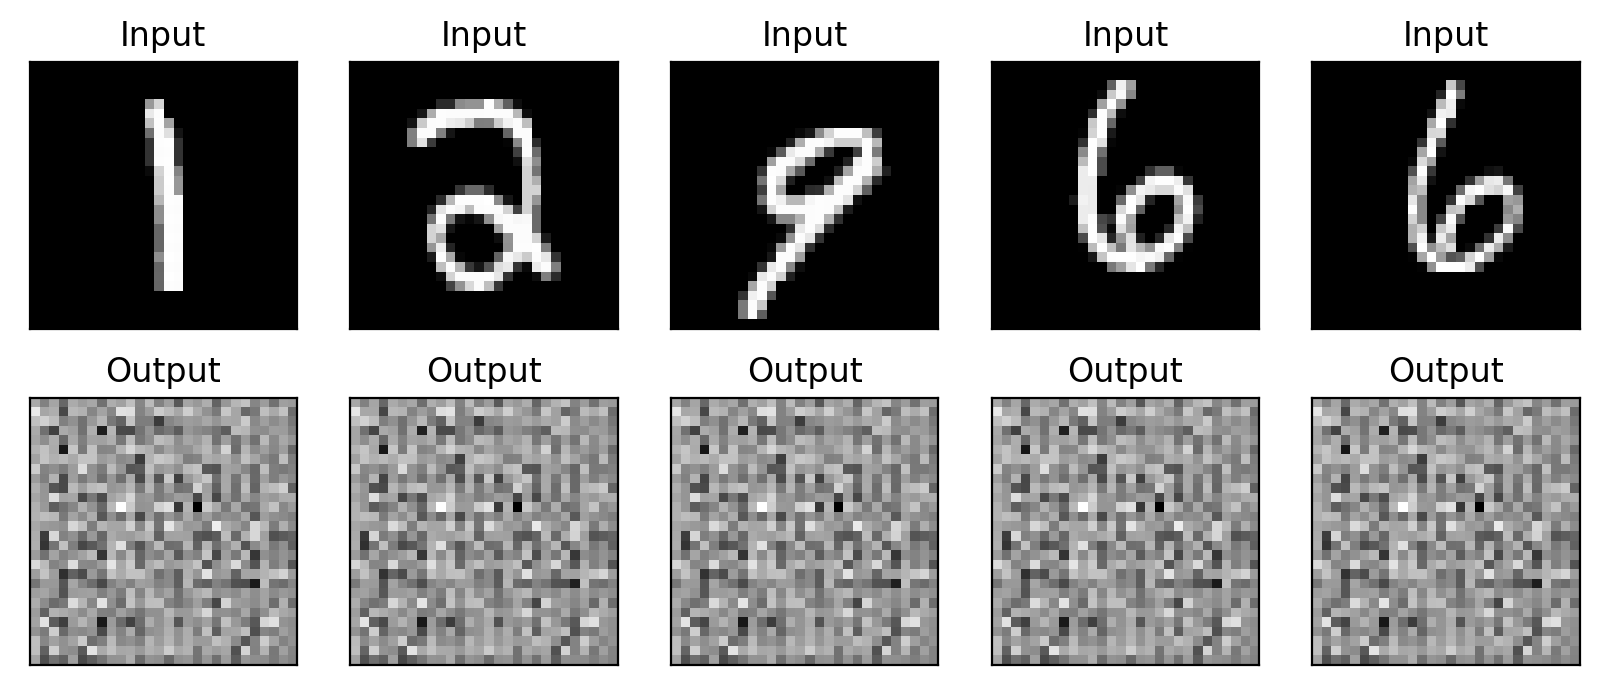

In [13]:
CAE = ConvAE()
print_nparameters(CAE)
plot_result(CAE)

In [14]:
CAE = ConvAE()
optimizer = optim.Adam(CAE.parameters(), lr=1e-3)
_ = AE_train(CAE, lossAE, optimizer, epochs=3, plot=True, verbose=True, freq=100)
plot_result(CAE)
plotLatentScatter(CAE.encoder_function, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
plotLatentScatter(CAE.encoder_function, classes=[0, 1])
plot_denoising(CAE)
plot_anomalies(CAE, mode="transpose")
plot_anomalies(CAE, mode="artifacts")
plot_anomalies(CAE, mode="mixing")

Start training...


NameError: name 'device' is not defined

In [ ]:
CAE = ConvAE(20)
optimizer = optim.Adam(CAE.parameters(), lr=1e-3)
_ = AE_train(CAE, lossAE, optimizer, epochs=3, plot=True, verbose=True, freq=100)
plot_result(CAE)

NameError: name 'ConvAE' is not defined

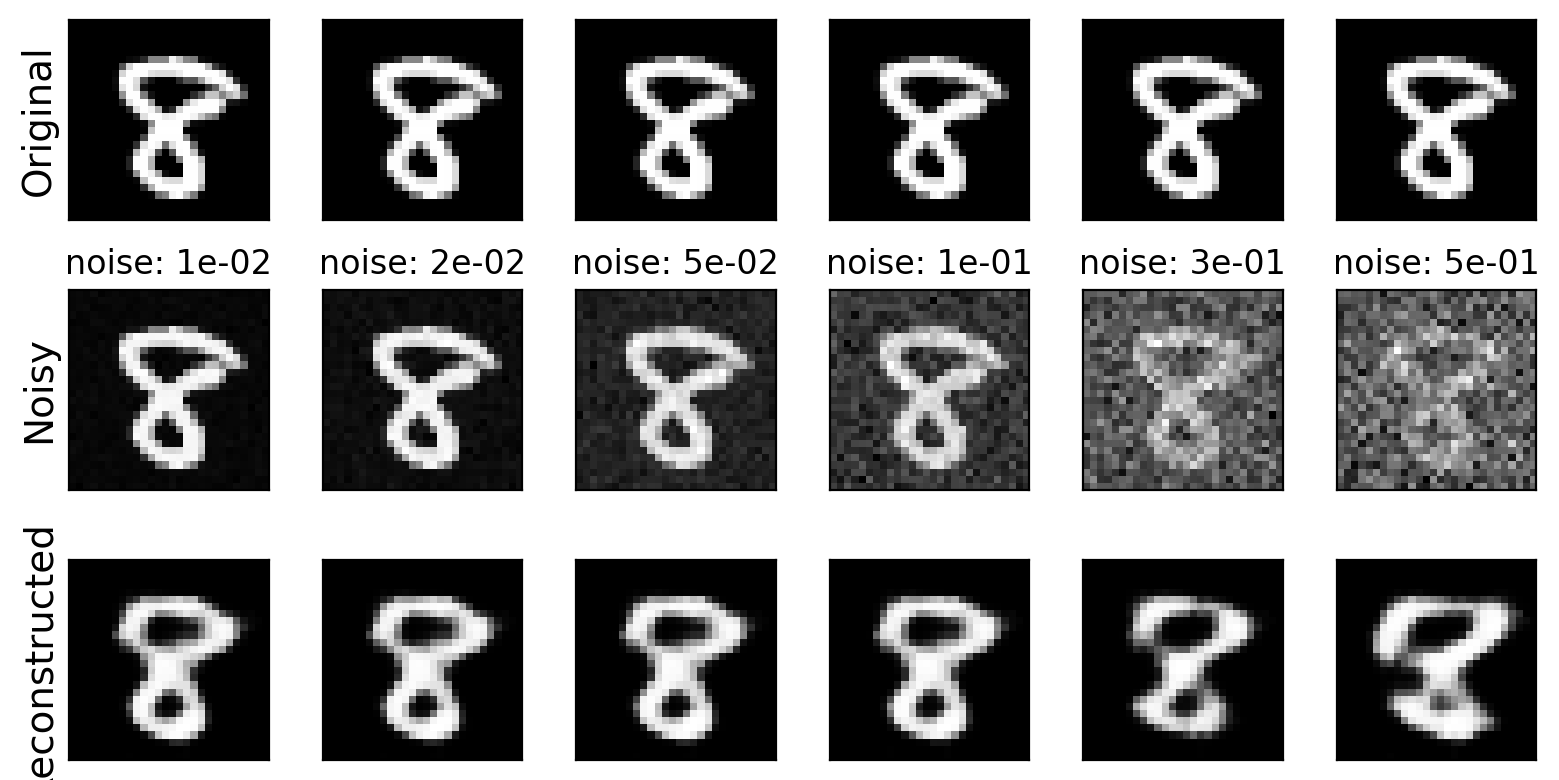

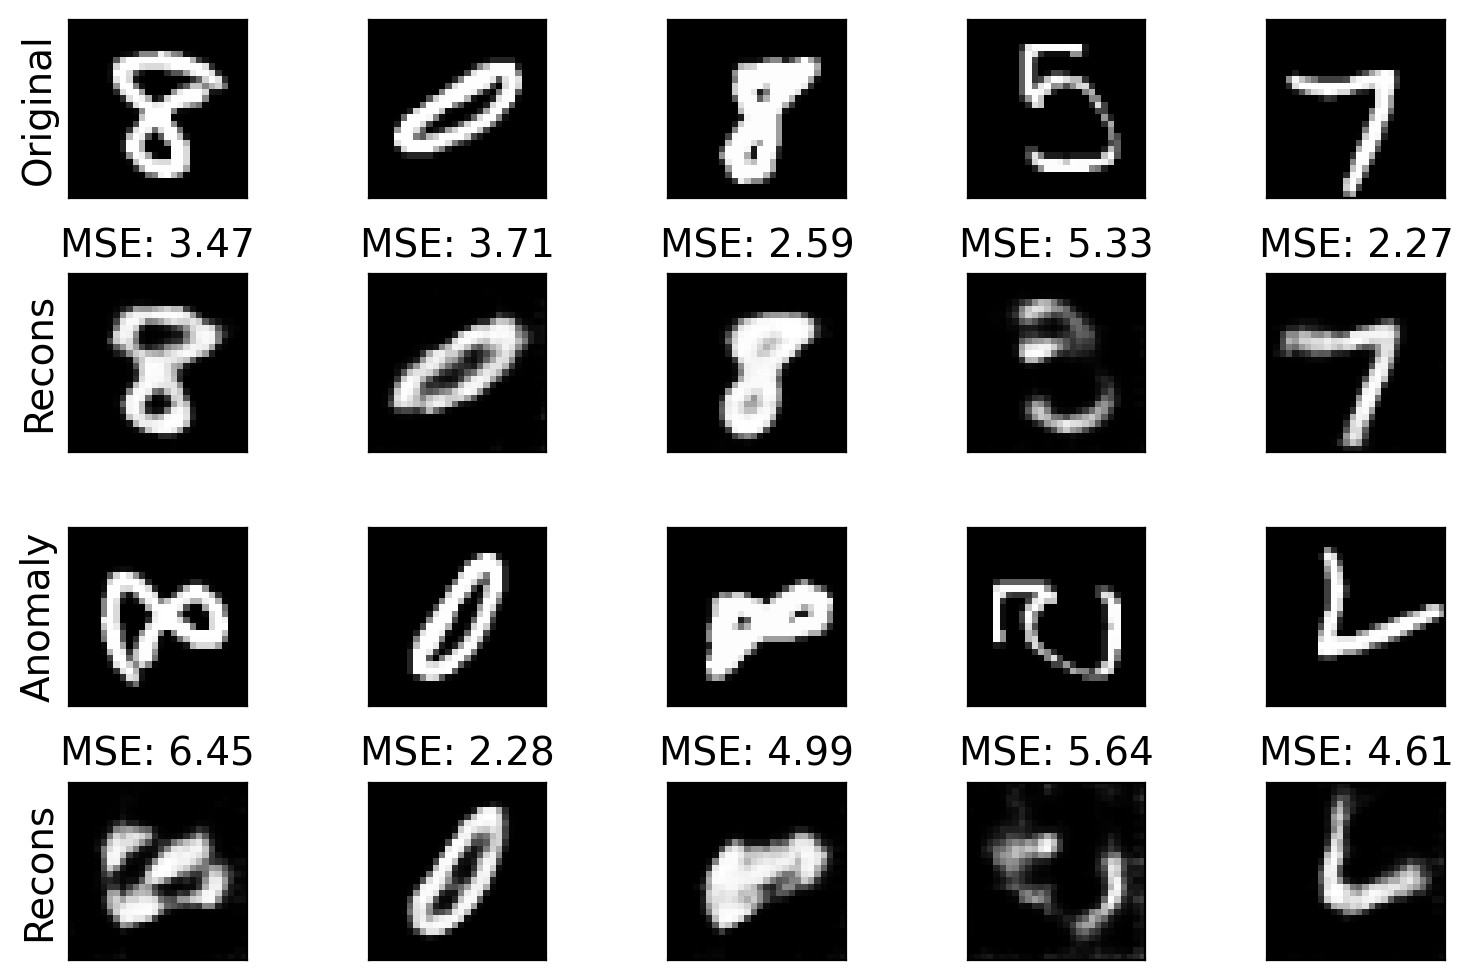

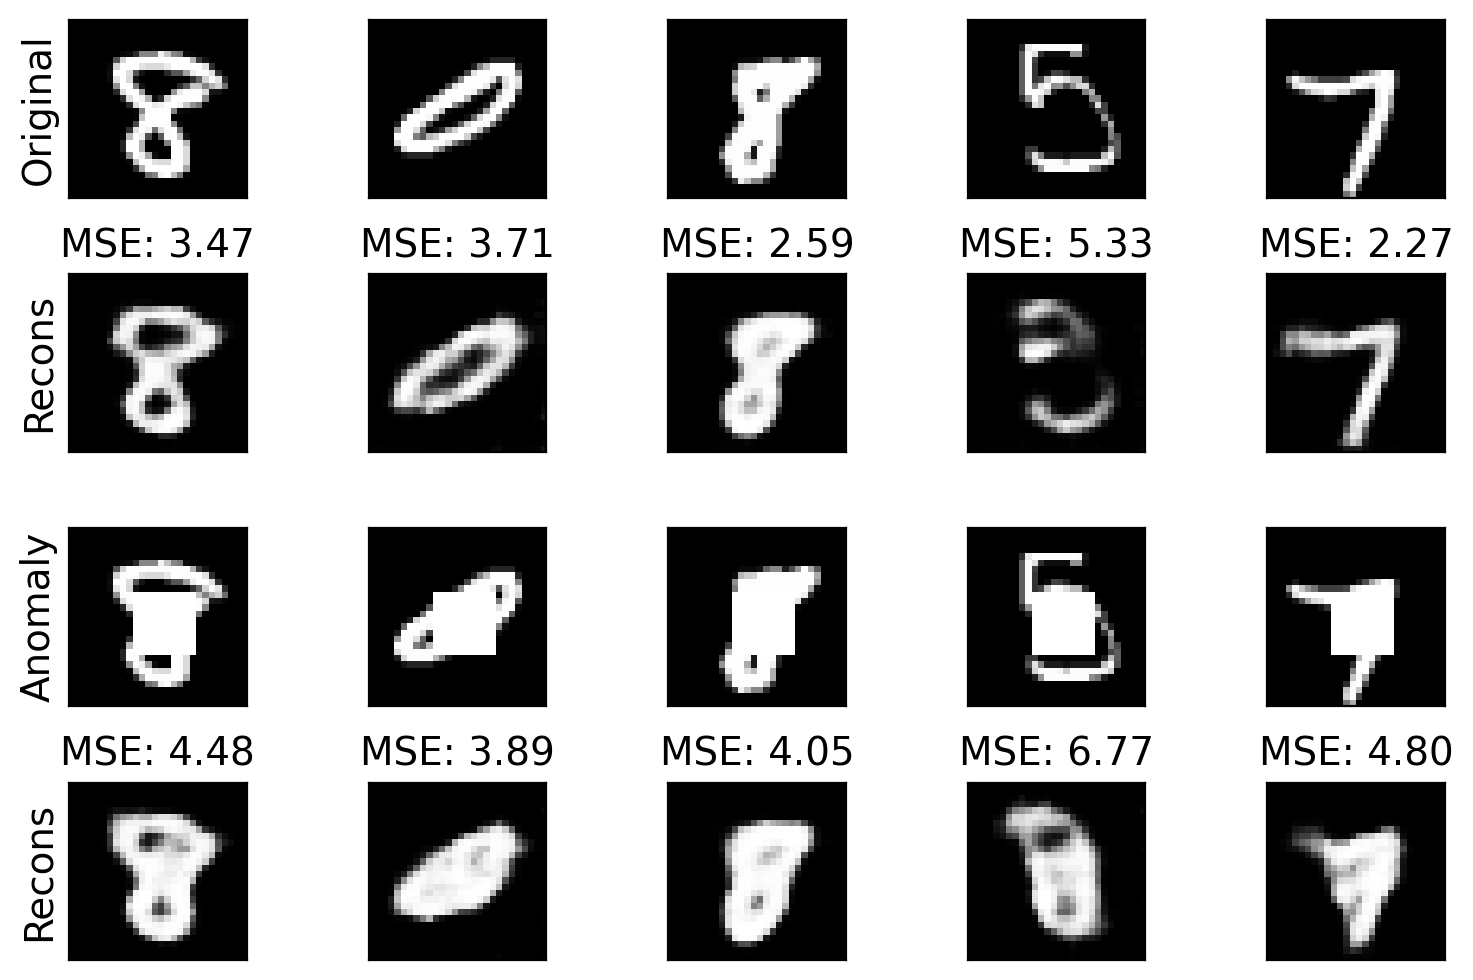

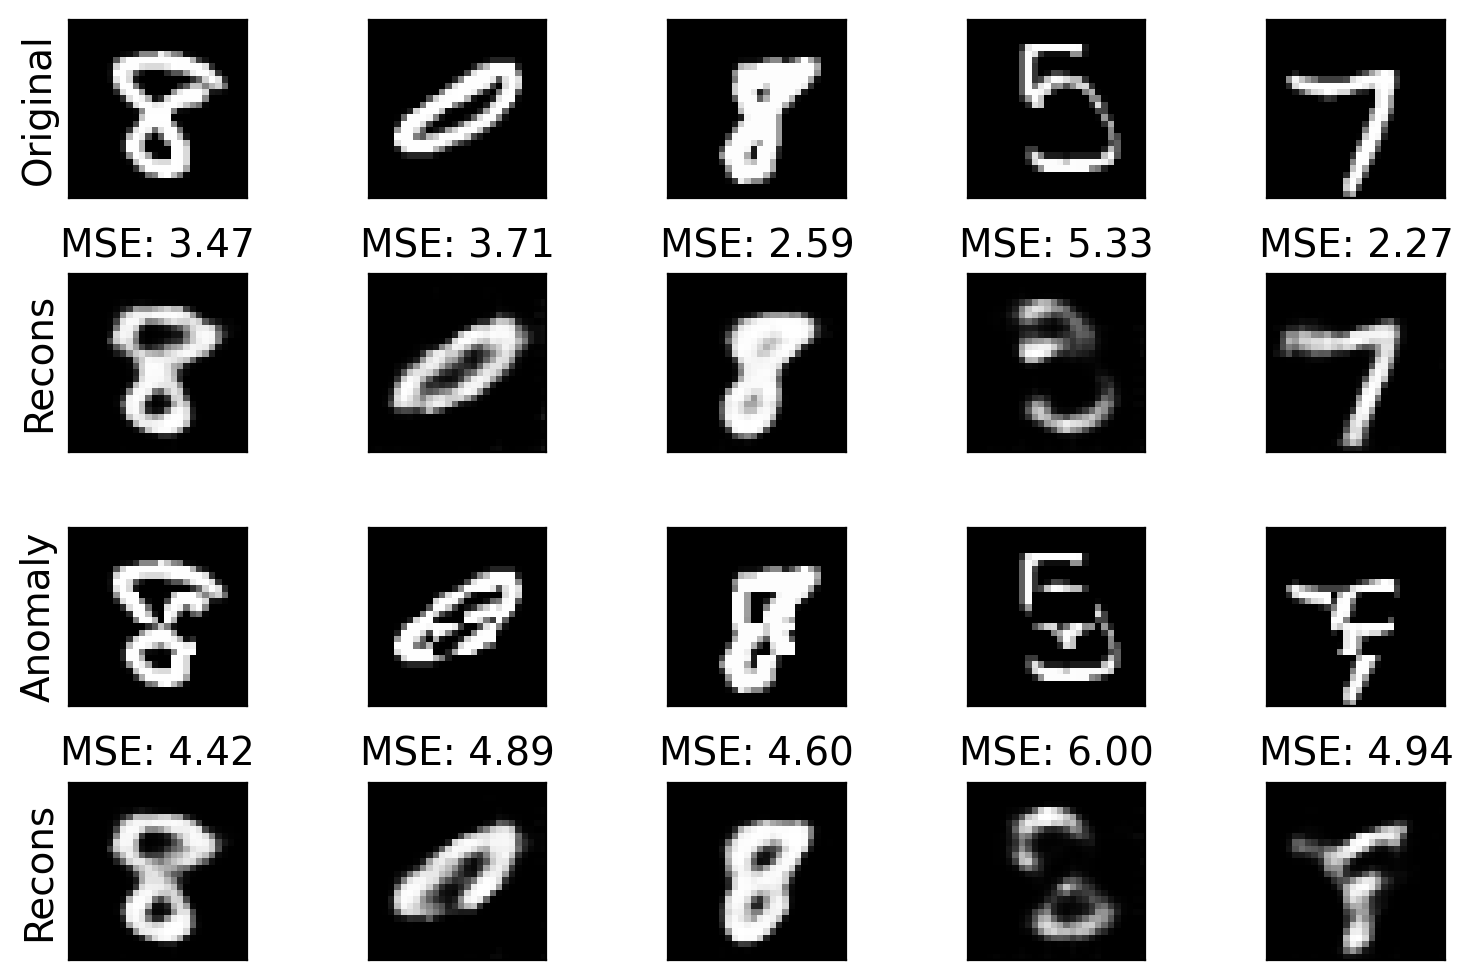

In [ ]:
plot_denoising(CAE)
plot_anomalies(CAE, mode="transpose")
plot_anomalies(CAE, mode="artifacts")
plot_anomalies(CAE, mode="mixing")

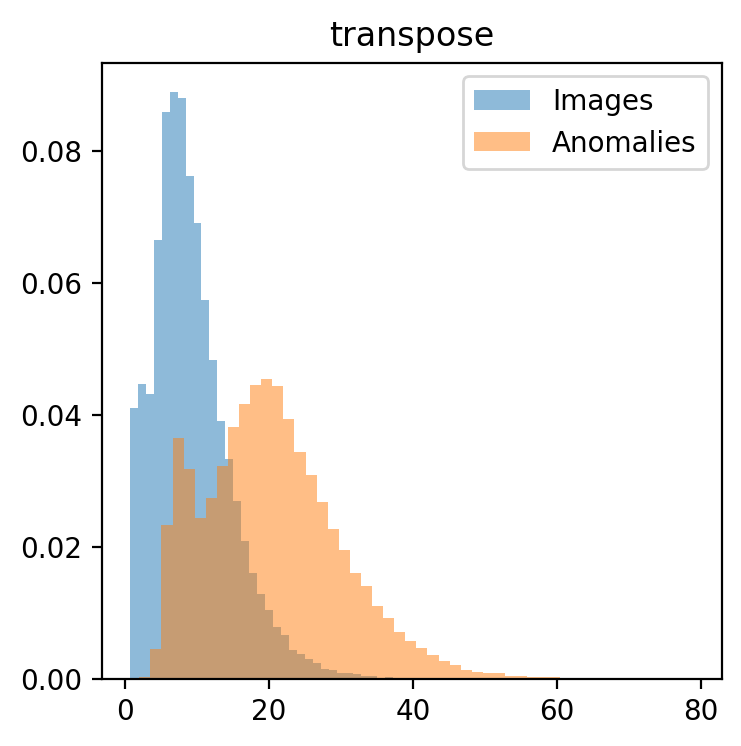

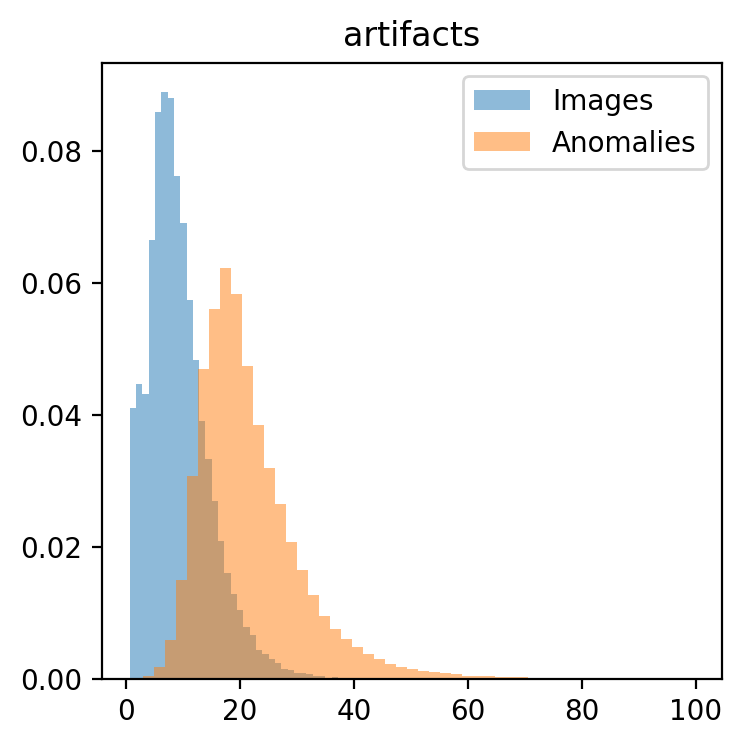

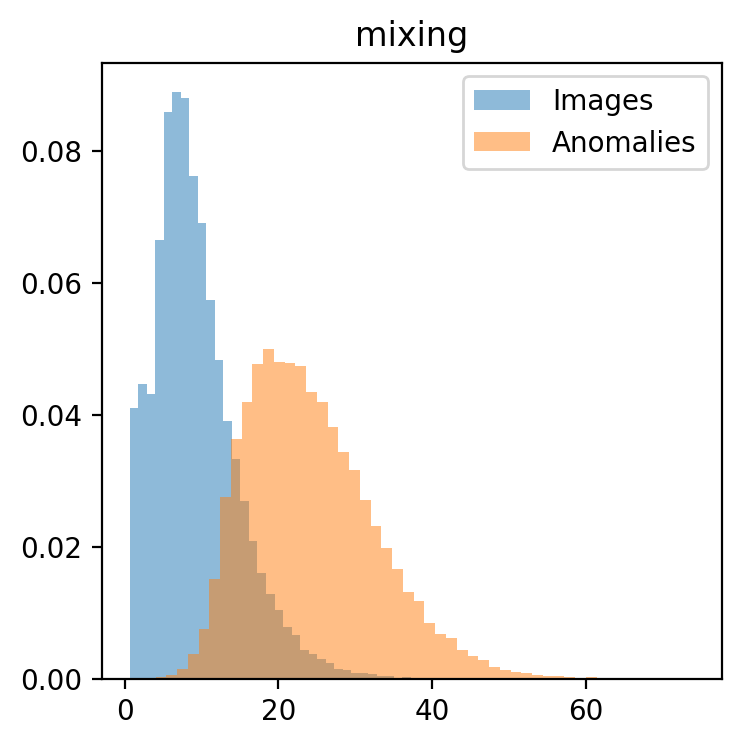

In [ ]:
detect_anomalies(CAE, train_loader, mode="transpose")
detect_anomalies(CAE, train_loader, mode="artifacts")
detect_anomalies(CAE, train_loader, mode="mixing")